Looking at Amazon's robots.txt file (or Twitter's, or Facebook's), you may be surprised to see them prohibit or severely restrict scraping.  Aren't there a lot of projects online using Twitter data?  And how dare they keep all that delicious, delicious information to themselves?  But before you start setting `'ROBOTSTXT_OBEY' = False`, read on!

Most of The Big Websites (Google, Facebook, Twitter, etc) have APIs that allow you to access their information programmatically without using webpages.  This is good for both you and the website.  With an API, you can ask the server to send you only the specific information you want, without having to retrieve, filter out, and discard the CSS, HTML, PHP, and other code from the website.  This minimizes demand on the server and speeds up your task.  

APIs typically include their own throttling to keep you from overloading the server, usually done by limiting the number of server requests per hour to a certain number.  

To access an API, you will usually need an API key or token that uniquely identifies you.  This lets the company or service providing the API keep an eye on your usage and track what you are doing.  Different API keys can also be associated with different levels of authorization and access, so they work as a data security measure.  Keys or tokens may also be set to expire after a certain amount of time or number of uses.

## Anatomy of an API

*Access*- You request a key.  Your program provides the key with each API call, and it determines what your program can do in the API.  
*Requests*- Your program requests the data you want with a call to the API.  The request will be made up of a method (type of query, using language defined by the API) and parameters (refine the query).  
*Response*- The data returned by the API, usually in a common format such as JSON that your program can parse.  

The specific syntax for each of these elements, and the format of the response, will vary from API to API.  In addition, APIs vary widely in their level of documentation and ease of use.  Before diving too deeply into an API-scraping project, do some judicious googling and if you see a lot of posts [like this one](https://mollyrocket.com/casey/stream_0029.html) consider going elsewhere.  Not all websites put their APIs front-and-center (did you know there are APIs for [NASA](https://api.nasa.gov/), [Marvel Comics](http://developer.marvel.com/), and [Star Wars](https://swapi.co/)?) so google will be your friend there as well.

## Basics of API Queries: Wikipedia's API

The process of using an API sounds a lot like scraping (make request, get response), but with an occasional added authorization layer.  Scrapy can handle authorization, so we can use it to access APIs too.

That said, the first API we'll pull from is [Wikipedia's](https://www.mediawiki.org/wiki/API:Main_page), which doesn't require an authorization key.  Aside from needing to master the API's language, you'll find that using scrapy with an API is very similar to using scrapy on a website.

We want to know what other entries on Wikipedia link to the [Monty Python](https://en.wikipedia.org/wiki/Monty_Python) page.  To do this, we can build a query using the [Wikipedia API Sandbox](https://en.wikipedia.org/wiki/Special:ApiSandbox).  Someone who is comfortable with the MediaWiki API syntax wouldn't need to use the sandbox, but for beginners it is very handy.  Note that API queries are nothing like SQL queries in syntax, despite their shared name.

The query we will use looks like this:
`https://en.wikipedia.org/w/api.php?action=query&format=xml&prop=linkshere&titles=Monty_Python&lhprop=title%7Credirect`

Let's break that down into it's components:

* `w/api.php`
    * Tells the server that we are using the API to pull info, rather than scraping the raw pages.  
    
* `action=query`   
    * We want information from the API (as opposed to changing information in the API)  
    
* `format=xml`  
    * Format the return in xml- then we will parse it with xpath  
    
* `prop=linkshere`  
    * We are interested in which pages link to our target page 
    
* `titles=Monty_Python`  
    * The target page is the Monty Python page.  Note that we used the exact name of the wikipedia page (Monty_Python).  
    
* `lhprop=title`  
    * From those links, we want the title of each page  
    
* `redirect`  
    * We also want to know if that link is a redirect  
    

The syntax of the MediaWiki API is based on php, thus the inclusion of `?` and `&` in the query.

For most of the query elements, we could have passed multiple arguments.  For example, we could request the URL as well as the title of the linking pages, or asked for all the pages that link to Monty_Python and to Monty_Python's_Flying_Circus.  

A query like this highlights why APIs are so handy.  Without an API, to find out the name of every page on Wikipedia that links to the Monty Python page we would have to scrape every single one of the 5,000,000+ articles in the English-language Wikipedia.  

If you haven't done so already, click on the query link above and see what it returns.



## Why use Scrapy for API calls

For some API calls, scrapy would be overkill.  If you know that your query can be answered in one response, then you don't need scrapy- you can use the `requests` library to make your API call and a library like `lxml` to parse the return.

The Wikipedia API, however, will only return ten items at a time in response to a query.  This sort of limitation is common to APIs to avoid overwhelming the server.  We can use scrapy to iterate over query results the same way that we iterated over the pages of the EverydaySexism website. 

Let's see the Wikipedia API and scrapy in action:



In [1]:
import scrapy
from scrapy.crawler import CrawlerProcess


class WikiSpider(scrapy.Spider):
    name = "WS"
    
    # Here is where we insert our API call.
    start_urls = [
        'https://en.wikipedia.org/w/api.php?action=query&format=xml&prop=linkshere&titles=Monty_Python&lhprop=title%7Credirect'
        ]

    # Identifying the information we want from the query response and extracting it using xpath.
    def parse(self, response):
        for item in response.xpath('//lh'):
            # The ns code identifies the type of page the link comes from.  '0' means it is a Wikipedia entry.
            # Other codes indicate links from 'Talk' pages, etc.  Since we are only interested in entries, we filter:
            if item.xpath('@ns').extract_first() == '0':
                yield {
                    'title': item.xpath('@title').extract_first() 
                    }
        # Getting the information needed to continue to the next ten entries.
        next_page = response.xpath('continue/@lhcontinue').extract_first()
        
        # Recursively calling the spider to process the next ten entries, if they exist.
        if next_page is not None:
            next_page = '{}&lhcontinue={}'.format(self.start_urls[0],next_page)
            yield scrapy.Request(next_page, callback=self.parse)
            
    
process = CrawlerProcess({
    'FEED_FORMAT': 'json',
    'FEED_URI': 'PythonLinks.json',
    # Note that because we are doing API queries, the robots.txt file doesn't apply to us.
    'ROBOTSTXT_OBEY': False,
    'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
    'AUTOTHROTTLE_ENABLED': True,
    'HTTPCACHE_ENABLED': True,
    'LOG_ENABLED': False,
    # We use CLOSESPIDER_PAGECOUNT to limit our scraper to the first 100 links.    
    'CLOSESPIDER_PAGECOUNT' : 10
})
                                         

# Starting the crawler with our spider.
process.crawl(WikiSpider)
process.start()
print('First 100 links extracted!')

First 100 links extracted!


In [2]:
import pandas as pd

# Checking whether we got data 

Monty=pd.read_json('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/PythonLinks.json', orient='records')
print(Monty.shape)
print(Monty.tail())

(92, 1)
                        title
87               Hans Moleman
88              Ripping Yarns
89  List of British comedians
90         Wensleydale cheese
91              Art Garfunkel


## Wrap up

Our API call was successful.  While we examined 100 links, we only saved 92 (the others weren't links from entry pages).  

We've barely scraped (pun intended) the surface of what scrapy and APIs can do.  Scrapy has changed a lot in the years since its debut, so when googling make sure the answers you see are from 2015 at the latest-- otherwise you'll likely not be able to use the code.  

Back to the issue of authorization keys- often the key is simply included in the query string as an additional arguments.  In other cases, if you need your scraper to be able to enter a key or login information into a form, scrapy [has you covered](http://stackoverflow.com/questions/30102199/form-authentication-login-a-site-using-scrapy).  

There's a lot of fun to be had in scraping and APIs-- it's a way to feel like you're getting a lot of information with very little effort!  Beware, however.  You're not getting information at all.  Scraping gives you *data*, an undifferentiated mess of bytes with no compelling meaning on its own.  Think of that list of Wiki entries that link to Monty Python.  It's cool that we could get it, but what does it mean?  Your job as a data scientist is to convert *data* to *information*-- something people can use to make decisions or understand the world.  Modeling data to get information is hard but worthwhile work, and its those kinds of projects that will really build your portfolio as you go on the market.  

That said, scraping up some original data can provide the *foundation* for an interesting and original final project.

## Challenge

Do a little scraping or API-calling of your own.  Pick a new website and see what you can get out of it.  Expect that you'll run into bugs and blind alleys, and rely on your mentor to help you get through.  

Formally, your goal is to write a scraper that will:

1) Return specific pieces of information (rather than just downloading a whole page)  
2) Iterate over multiple pages/queries  
3) Save the data to your computer  

Once you have your data, compute some statistical summaries and/or visualizations that give you some new insights into your scraping topic of interest.  Write up a report from scraping code to summary and share it with your mentor.

For this challenge, we will scrape Fanduel fantasy basketball player data from the following site:

http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=10&year=2019&game=fd

We will obtain data for the last three days of the 2018-19 regular season.

In [1]:
# Importing in each cell because of the kernel restarts.
import pandas as pd
import scrapy
from scrapy.crawler import CrawlerProcess

class DFSpider(scrapy.Spider):
    # Naming the spider is important if you are running more than one spider of
    # this class simultaneously.
    name = "DFS"
    
    # URL(s) to start with.
    start_urls = [
        'http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd'
    ]
    
    # Use XPath to parse the response we get.
    def parse(self, response):
        # Get the table rows
        trs = response.xpath('/html/body/table[1]//table[@cellspacing=5]//tr')
            
        # Remove first two rows since they don't contain any player data
        trs = trs[2:]
        
        # Iterate over every element on the page.
        if trs:
            print('trs exist')
     
        
            for tr in trs:
                print('entering for loop')
                print('testing')
                #test = tr.xpath('//td').extract()
                test = tr.xpath('./td[2]/a/text()').extract()
                print('test: ', test)

                # Yield a dictionary with the values we want.
                yield {
                    # This is the code to choose what we want to extract
                    # You can modify this with other Xpath expressions to extract other information from the site
                    'Name': tr.xpath('./td[2]/a/text()').extract(),
                    'Position': tr.xpath('./td[1]/text()').extract(),
                    'FD Pts': tr.xpath('./td[3]/text()').extract(),
                    'FD Salary': tr.xpath('./td[4]/text()').extract(),
                    'Team': tr.xpath('./td[5]/text()').extract(),
                    'Opp': tr.xpath('./td[6]/text()').extract(),
                    'Score': tr.xpath('./td[7]/text()').extract(),
                    'Min': tr.xpath('./td[8]/text()').extract(),
                    'Stats': tr.xpath('./td[9]/text()').extract()
                }
                
        # Select the table containing the next page link
        table = response.xpath('//table[@border=0]')[6]
        
        print('table: ', table)
        
        # Get the next page link
        next_page = table.xpath('./tr[1]/td[1]/a/@href').extract_first()
                
        print('next_page: ', next_page)
        
        # Run the parse function recursively on the next page link
        if next_page is not None:
            print('going to next page')
            yield scrapy.Request(next_page, callback=self.parse)
        
# Tell the script how to run the crawler by passing in settings.
process = CrawlerProcess({
    'FEED_FORMAT': 'json',
    'FEED_URI': 'nba_dfs_data.json',
    'DEPTH_LIMIT': 3,
    'DOWNLOAD_DELAY': 0.50,
    'LOG_ENABLED': True           # Turn off logging for now.
})

# Start the crawler with our spider.
process.crawl(DFSpider)
process.start()
print('Success!')


2019-08-31 00:44:46 [scrapy.utils.log] INFO: Scrapy 1.5.2 started (bot: scrapybot)
2019-08-31 00:44:46 [scrapy.utils.log] INFO: Versions: lxml 3.7.3.0, libxml2 2.9.8, cssselect 1.0.3, parsel 1.5.1, w3lib 1.20.0, Twisted 18.9.0, Python 3.6.7 | packaged by conda-forge | (default, Feb 28 2019, 02:16:08) - [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)], pyOpenSSL 19.0.0 (OpenSSL 1.1.1  11 Sep 2018), cryptography 2.7, Platform Darwin-17.4.0-x86_64-i386-64bit
2019-08-31 00:44:46 [scrapy.crawler] INFO: Overridden settings: {'DEPTH_LIMIT': 3, 'DOWNLOAD_DELAY': 0.5, 'FEED_FORMAT': 'json', 'FEED_URI': 'nba_dfs_data.json'}
2019-08-31 00:44:46 [scrapy.extensions.telnet] INFO: Telnet Password: 261fc6dcdb2c6c62
2019-08-31 00:44:46 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.extensions.feedexport.FeedExporter',
 'scrapy.extensions.logstats.LogStats']


2019-08-31 00:44:48 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Fournier, Evan'], 'Position': ['SG'], 'FD Pts': ['37.5'], 'FD Salary': ['$6,000'], 'Team': ['orl'], 'Opp': ['@ bos'], 'Score': ['\xa0116-108'], 'Min': ['35:52'], 'Stats': [' \xa0 24pt 5rb 3as 2st 3to 3trey 8-16fg 5-5ft']}
2019-08-31 00:44:48 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ["Russell, D'Angelo"], 'Position': ['SG'], 'FD Pts': ['36.2'], 'FD Salary': ['$9,100'], 'Team': ['bkn'], 'Opp': ['@ ind'], 'Score': ['\xa0108-96'], 'Min': ['29:11'], 'Stats': [' \xa0 20pt 6rb 6as 1bl 3to 1trey 7-15fg 5-5ft']}
2019-08-31 00:44:48 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Ross, Terrence'], 'Position': ['SG'], 'FD Pts': ['36.1'], 'FD Salary': ['$5,700'], 'Team': ['orl'], 'Opp': ['@ bo

2019-08-31 00:44:48 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Satoransky, Tomas'], 'Position': ['PG'], 'FD Pts': ['27.5'], 'FD Salary': ['$5,600'], 'Team': ['was'], 'Opp': ['@ nyk'], 'Score': ['\xa0110-113'], 'Min': ['31:47'], 'Stats': [' \xa0 7pt 5rb 7as 2st 2to 3-8fg 1-1ft']}
2019-08-31 00:44:48 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Hield, Buddy'], 'Position': ['SG'], 'FD Pts': ['27'], 'FD Salary': ['$7,100'], 'Team': ['sac'], 'Opp': ['v nor'], 'Score': ['\xa0129-133'], 'Min': ['31:35'], 'Stats': [' \xa0 12pt 5rb 6as 1st 3to 2trey 5-15fg']}
2019-08-31 00:44:48 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Shamet, Landry'], 'Position': ['PG'], 'FD Pts': ['26.6'], 'FD Salary': ['$4,100'], 'Team': ['lac'], 'Opp': ['@ gsw'], 'Score': ['\

trs exist
entering for loop
testing
test:  ['Westbrook, Russell']
entering for loop
testing
test:  ['Payton, Elfrid']
entering for loop
testing
test:  ['Harden, James']
entering for loop
testing
test:  ["Fox, De'Aaron"]
entering for loop
testing
test:  ['Wright, Delon']
entering for loop
testing
test:  ['Walker, Kemba']
entering for loop
testing
test:  ['Clark, Ian']
entering for loop
testing
test:  ['Caldwell-Pope, Kentavious']
entering for loop
testing
test:  ['Curry, Stephen']
entering for loop
testing
test:  ['Holiday, Justin']
entering for loop
testing
test:  ['Lillard, Damian']
entering for loop
testing
test:  ['Crawford, Jamal']
entering for loop
testing
test:  ['Irving, Kyrie']
entering for loop
testing
test:  ['Wiggins, Andrew']
entering for loop
testing
test:  ['Augustin, D.J.']
entering for loop
testing
test:  ['Fournier, Evan']
entering for loop
testing
test:  ["Russell, D'Angelo"]
entering for loop
testing
test:  ['Ross, Terrence']
entering for loop
testing
test:  ['Paul, 

2019-08-31 00:44:48 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Bledsoe, Eric'], 'Position': ['PG'], 'FD Pts': ['26.5'], 'FD Salary': ['$7,900'], 'Team': ['mil'], 'Opp': ['v atl'], 'Score': ['\xa0115-107'], 'Min': ['24:20'], 'Stats': [' \xa0 8pt 5rb 5as 2st 1to 4-10fg']}
2019-08-31 00:44:48 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Beal, Bradley'], 'Position': ['SG'], 'FD Pts': ['26.1'], 'FD Salary': ['$8,700'], 'Team': ['was'], 'Opp': ['@ nyk'], 'Score': ['\xa0110-113'], 'Min': ['23:26'], 'Stats': [' \xa0 13pt 3rb 5as 1st 1to 2trey 5-17fg 1-1ft']}
2019-08-31 00:44:48 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Dragic, Goran'], 'Position': ['PG'], 'FD Pts': ['26'], 'FD Salary': ['$7,200'], 'Team': ['mia'], 'Opp': ['@ tor'], 'Score': ['\xa0

test:  ['Bledsoe, Eric']
entering for loop
testing
test:  ['Beal, Bradley']
entering for loop
testing
test:  ['Dragic, Goran']
entering for loop
testing
test:  ['Schroder, Dennis']
entering for loop
testing
test:  ['Randle, Chasson']
entering for loop
testing
test:  ['Forbes, Bryn']
entering for loop
testing
test:  ['Ellington, Wayne']
entering for loop
testing
test:  ['Carter-Williams, Michael']
entering for loop
testing
test:  ['Craig, Torrey']
entering for loop
testing
test:  ['Waiters, Dion']
entering for loop
testing
test:  ['Okobo, Elie']
entering for loop
testing
test:  ['Beasley, Malik']
entering for loop
testing
test:  ['Ferrell, Yogi']
entering for loop
testing
test:  ['Mills, Patty']
entering for loop
testing
test:  ['Smith Jr., Dennis']
entering for loop
testing
test:  ['Macon, Daryl']
entering for loop
testing
test:  ['Smart, Marcus']
entering for loop
testing
test:  ['Connaughton, Pat']
entering for loop
testing
test:  ['Sexton, Collin']
entering for loop
testing
test:  [

2019-08-31 00:44:48 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Hill, George'], 'Position': ['PG'], 'FD Pts': ['17.4'], 'FD Salary': ['$4,600'], 'Team': ['mil'], 'Opp': ['v atl'], 'Score': ['\xa0115-107'], 'Min': ['20:58'], 'Stats': [' \xa0 9pt 7rb 2as 3to 1trey 2-8fg 4-6ft']}
2019-08-31 00:44:48 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Brown, Bruce'], 'Position': ['SG'], 'FD Pts': ['16.8'], 'FD Salary': ['$3,500'], 'Team': ['det'], 'Opp': ['v cha'], 'Score': ['\xa091-104'], 'Min': ['23:41'], 'Stats': [' \xa0 6pt 4rb 2as 1st 2-4fg 2-2ft']}
2019-08-31 00:44:48 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Bacon, Dwayne'], 'Position': ['SG'], 'FD Pts': ['16.7'], 'FD Salary': ['$3,700'], 'Team': ['cha'], 'Opp': ['@ det'], 'Score': ['\xa0104-91

2019-08-31 00:44:49 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Galloway, Langston'], 'Position': ['SG'], 'FD Pts': ['9.2'], 'FD Salary': ['$3,500'], 'Team': ['det'], 'Opp': ['v cha'], 'Score': ['\xa091-104'], 'Min': ['16:32'], 'Stats': [' \xa0 2pt 1rb 1st 1bl 1-7fg']}
2019-08-31 00:44:49 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['McGruder, Rodney'], 'Position': ['SG'], 'FD Pts': ['9.2'], 'FD Salary': ['$3,500'], 'Team': ['mia'], 'Opp': ['@ tor'], 'Score': ['\xa0109-117'], 'Min': ['22:36'], 'Stats': [' \xa0 2pt 6rb 1-6fg 0-2ft']}
2019-08-31 00:44:49 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Wallace, Tyrone'], 'Position': ['SG'], 'FD Pts': ['8.9'], 'FD Salary': ['$3,500'], 'Team': ['lac'], 'Opp': ['@ gsw'], 'Score': ['\xa0104-131'], 'Min':

entering for loop
testing
test:  ['Hill, George']
entering for loop
testing
test:  ['Brown, Bruce']
entering for loop
testing
test:  ['Bacon, Dwayne']
entering for loop
testing
test:  ['Bazemore, Kent']
entering for loop
testing
test:  ['Robinson, Jerome']
entering for loop
testing
test:  ['Brown, Sterling']
entering for loop
testing
test:  ['Kennard, Luke']
entering for loop
testing
test:  ['Thompson, Klay']
entering for loop
testing
test:  ['Lee, Damion']
entering for loop
testing
test:  ['Cook, Quinn']
entering for loop
testing
test:  ['Holiday, Aaron']
entering for loop
testing
test:  ['Curry, Seth']
entering for loop
testing
test:  ['Walker, Lonnie']
entering for loop
testing
test:  ['VanVleet, Fred']
entering for loop
testing
test:  ['Livingston, Shaun']
entering for loop
testing
test:  ['Anderson, Justin']
entering for loop
testing
test:  ['Carter, Jevon']
entering for loop
testing
test:  ['Pondexter, Quincy']
entering for loop
testing
test:  ['Rozier, Terry']
entering for loop


2019-08-31 00:44:49 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Reed, Davon'], 'Position': ['SG'], 'FD Pts': ['0'], 'FD Salary': ['$3,500'], 'Team': ['ind'], 'Opp': ['v bkn'], 'Score': ['\xa096-108'], 'Min': ['2:25'], 'Stats': [' \xa0 0pt']}
2019-08-31 00:44:49 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Sumner, Edmond'], 'Position': ['PG'], 'FD Pts': ['0'], 'FD Salary': ['$3,500'], 'Team': ['ind'], 'Opp': ['v bkn'], 'Score': ['\xa096-108'], 'Min': ['2:25'], 'Stats': [' \xa0 0pt']}
2019-08-31 00:44:49 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Mason III, Frank'], 'Position': ['SG'], 'FD Pts': ['0'], 'FD Salary': ['$3,500'], 'Team': ['sac'], 'Opp': ['v nor'], 'Score': ['\xa0129-133'], 'Min': ['DNP'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:49 

2019-08-31 00:44:49 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Meeks, Jodie'], 'Position': ['SG'], 'FD Pts': ['0'], 'FD Salary': ['$3,500'], 'Team': ['tor'], 'Opp': ['v mia'], 'Score': ['\xa0117-109'], 'Min': ['DNP'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:49 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Williams, C.J.'], 'Position': ['SG'], 'FD Pts': ['0'], 'FD Salary': ['$3,600'], 'Team': ['min'], 'Opp': ['v okc'], 'Score': ['\xa0126-132'], 'Min': ['DNP'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:49 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Parker, Tony'], 'Position': ['PG'], 'FD Pts': ['0'], 'FD Salary': ['$3,500'], 'Team': ['cha'], 'Opp': ['@ det'], 'Score': ['\xa0104-91'], 'Min': ['DNP'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:49 [scrapy.co


testing
test:  ['Reed, Davon']
entering for loop
testing
test:  ['Sumner, Edmond']
entering for loop
testing
test:  ['Mason III, Frank']
entering for loop
testing
test:  ['Simons, Anfernee']
entering for loop
testing
test:  ['Robinson, Duncan']
entering for loop
testing
test:  ['Bullock, Reggie']
entering for loop
testing
test:  ['Burton, Deonte']
entering for loop
testing
test:  ['Mack, Shelvin']
entering for loop
testing
test:  ['Garrett, Billy']
entering for loop
testing
test:  ['Lin, Jeremy']
entering for loop
testing
test:  ['Rondo, Rajon']
entering for loop
testing
test:  ['Diallo, Hamidou']
entering for loop
testing
test:  ['Mitrou-Long, Nazareth']
entering for loop
testing
test:  ['Booker, Devin']
entering for loop
testing
test:  ['Conley, Mike']
entering for loop
testing
test:  ['Young, Trae']
entering for loop
testing
test:  ['Jackson, Frank']
entering for loop
testing
test:  ['Bayless, Jerryd']
entering for loop
testing
test:  ['Stauskas, Nik']
entering for loop
testing
tes

2019-08-31 00:44:49 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Allen, Kadeem'], 'Position': ['PG'], 'FD Pts': ['0'], 'FD Salary': ['$4,000'], 'Team': ['nyk'], 'Opp': ['v was'], 'Score': ['\xa0113-110'], 'Min': ['NA'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:49 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Bluiett, Trevon'], 'Position': ['SG'], 'FD Pts': ['0'], 'FD Salary': ['$3,500'], 'Team': ['nor'], 'Opp': ['@ sac'], 'Score': ['\xa0133-129'], 'Min': ['NA'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:49 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Caupain, Troy'], 'Position': ['PG'], 'FD Pts': ['0'], 'FD Salary': ['$3,600'], 'Team': ['orl'], 'Opp': ['@ bos'], 'Score': ['\xa0116-108'], 'Min': ['NA'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:49 [scrapy.c

2019-08-31 00:44:49 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': [], 'Position': [' \xa0 \xa0 ', ' \xa0 | \xa0 ', ' \xa0 | \xa0 ', ' \xa0 | \xa0 ', ' \xa0 | '], 'FD Pts': [], 'FD Salary': [], 'Team': [], 'Opp': [], 'Score': [], 'Min': [], 'Stats': []}
2019-08-31 00:44:49 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': [], 'Position': [], 'FD Pts': [], 'FD Salary': [], 'Team': [], 'Opp': [], 'Score': [], 'Min': [' \xa0 '], 'Stats': []}
2019-08-31 00:44:49 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Green, Draymond'], 'Position': ['PF'], 'FD Pts': ['57.5'], 'FD Salary': ['$7,100'], 'Team': ['gsw'], 'Opp': ['v lac'], 'Score': ['\xa0131-104'], 'Min': ['29:35'], 'Stats': [' \xa0 10pt 10rb 9as 5st 3bl 2to 4-9fg 2-2ft']}
2019-08-31 00:44:49 [scrapy.core.scr

['Allen, Kadeem']
entering for loop
testing
test:  ['Bluiett, Trevon']
entering for loop
testing
test:  ['Caupain, Troy']
entering for loop
testing
test:  ['Burks, Alec']
entering for loop
testing
test:  ['Trier, Allonzo']
entering for loop
testing
test:  ['Beverley, Patrick']
entering for loop
testing
test:  ['Dozier, PJ']
entering for loop
testing
test:  ['Rose, Derrick']
entering for loop
testing
test:  ['Evans, Jawun']
entering for loop
testing
test:  ['Neto, Raul']
entering for loop
testing
test:  ['Loyd, Jordan']
entering for loop
testing
test:  ['Mudiay, Emmanuel']
entering for loop
testing
test:  ['Exum, Dante']
entering for loop
testing
test:  ['Iguodala, Andre']
entering for loop
testing
test:  ['Murray, Jamal']
entering for loop
testing
test:  ['DiVincenzo, Donte']
entering for loop
testing
test:  ['Lucas, Kalin']
entering for loop
testing
test:  ['Doncic, Luka']
entering for loop
testing
test:  ['Hunter, R.J.']
entering for loop
testing
test:  ['Dellavedova, Matthew']
enter

2019-08-31 00:44:49 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Caboclo, Bruno'], 'Position': ['SF'], 'FD Pts': ['40.4'], 'FD Salary': ['$5,000'], 'Team': ['mem'], 'Opp': ['v dal'], 'Score': ['\xa0127-129'], 'Min': ['39:27'], 'Stats': [' \xa0 13pt 17rb 4as 1bl 2to 3trey 4-10fg 2-2ft']}
2019-08-31 00:44:49 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Jones, Jemerrio'], 'Position': ['PF'], 'FD Pts': ['39.7'], 'FD Salary': ['$3,600'], 'Team': ['lal'], 'Opp': ['v uta'], 'Score': ['\xa0113-109'], 'Min': ['37:37'], 'Stats': [' \xa0 5pt 16rb 5as 1st 2bl 1to 1trey 2-5fg']}
2019-08-31 00:44:49 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Bagley, Marvin'], 'Position': ['PF'], 'FD Pts': ['38.8'], 'FD Salary': ['$6,700'], 'Team': ['sac'], 'Opp': ['v nor']

2019-08-31 00:44:49 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Saric, Dario'], 'Position': ['PF'], 'FD Pts': ['30.1'], 'FD Salary': ['$5,300'], 'Team': ['min'], 'Opp': ['v okc'], 'Score': ['\xa0126-132'], 'Min': ['32:26'], 'Stats': [' \xa0 23pt 3rb 1as 1bl 1to 5trey 9-15fg']}
2019-08-31 00:44:49 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Hayward, Gordon'], 'Position': ['SF'], 'FD Pts': ['30'], 'FD Salary': ['$5,800'], 'Team': ['bos'], 'Opp': ['v orl'], 'Score': ['\xa0108-116'], 'Min': ['37:59'], 'Stats': [' \xa0 16pt 5rb 4as 1st 1to 8-14fg']}
2019-08-31 00:44:49 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Bender, Dragan'], 'Position': ['PF'], 'FD Pts': ['29.6'], 'FD Salary': ['$5,000'], 'Team': ['pho'], 'Opp': ['@ hou'], 'Score': ['\xa0113

entering for loop
testing
test:  ['Caboclo, Bruno']
entering for loop
testing
test:  ['Jones, Jemerrio']
entering for loop
testing
test:  ['Bagley, Marvin']
entering for loop
testing
test:  ['Aldridge, LaMarcus']
entering for loop
testing
test:  ['Barnes, Harrison']
entering for loop
testing
test:  ['Aminu, Al-Farouq']
entering for loop
testing
test:  ['Knox, Kevin']
entering for loop
testing
test:  ['Durant, Kevin']
entering for loop
testing
test:  ['Winslow, Justise']
entering for loop
testing
test:  ['Kaminsky, Frank']
entering for loop
testing
test:  ['Sefolosha, Thabo']
entering for loop
testing
test:  ['Leonard, Kawhi']
entering for loop
testing
test:  ['Jackson, Josh']
entering for loop
testing
test:  ['Johnson, James']
entering for loop
testing
test:  ['Finney-Smith, Dorian']
entering for loop
testing
test:  ['Siakam, Pascal']
entering for loop
testing
test:  ['Brown Jr., Troy']
entering for loop
testing
test:  ['Sabonis, Domantas']
entering for loop
testing
test:  ['Bridges, M

2019-08-31 00:44:49 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Ibaka, Serge'], 'Position': ['PF'], 'FD Pts': ['26'], 'FD Salary': ['$5,700'], 'Team': ['tor'], 'Opp': ['v mia'], 'Score': ['\xa0117-109'], 'Min': ['19:17'], 'Stats': [' \xa0 12pt 5rb 3bl 1to 6-14fg']}
2019-08-31 00:44:49 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Adebayo, Bam'], 'Position': ['PF'], 'FD Pts': ['25.6'], 'FD Salary': ['$7,500'], 'Team': ['mia'], 'Opp': ['@ tor'], 'Score': ['\xa0109-117'], 'Min': ['31:09'], 'Stats': [' \xa0 7pt 13rb 2as 1st 3to 2-7fg 3-4ft']}
2019-08-31 00:44:49 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Green, Jeff'], 'Position': ['SF'], 'FD Pts': ['24.9'], 'FD Salary': ['$4,200'], 'Team': ['was'], 'Opp': ['@ nyk'], 'Score': ['\xa0110-113'], 'Mi

2019-08-31 00:44:49 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Crowder, Jae'], 'Position': ['SF'], 'FD Pts': ['20.2'], 'FD Salary': ['$4,800'], 'Team': ['uta'], 'Opp': ['@ lal'], 'Score': ['\xa0109-113'], 'Min': ['22:45'], 'Stats': [' \xa0 11pt 6rb 2as 1to 1trey 4-12fg 2-2ft']}
2019-08-31 00:44:49 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Motley, Johnathan'], 'Position': ['PF'], 'FD Pts': ['19.7'], 'FD Salary': ['$3,500'], 'Team': ['lac'], 'Opp': ['@ gsw'], 'Score': ['\xa0104-131'], 'Min': ['12:00'], 'Stats': [' \xa0 9pt 6rb 1as 1st 1to 4-6fg 1-2ft']}
2019-08-31 00:44:49 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Wilson, D.J.'], 'Position': ['PF'], 'FD Pts': ['19.4'], 'FD Salary': ['$3,600'], 'Team': ['mil'], 'Opp': ['v atl'], 'Score': [


testing
test:  ['Ibaka, Serge']
entering for loop
testing
test:  ['Adebayo, Bam']
entering for loop
testing
test:  ['Green, Jeff']
entering for loop
testing
test:  ['Hill, Solomon']
entering for loop
testing
test:  ['Wood, Christian']
entering for loop
testing
test:  ['Powell, Dwight']
entering for loop
testing
test:  ['Diallo, Cheick']
entering for loop
testing
test:  ['Young, Thaddeus']
entering for loop
testing
test:  ['Harrell, Montrezl']
entering for loop
testing
test:  ['Niang, Georges']
entering for loop
testing
test:  ['Bogdanovic, Bojan']
entering for loop
testing
test:  ['Griffin, Blake']
entering for loop
testing
test:  ['Robinson, Devin']
entering for loop
testing
test:  ['Williams, Johnathan']
entering for loop
testing
test:  ["O'Neale, Royce"]
entering for loop
testing
test:  ['Portis, Bobby']
entering for loop
testing
test:  ['Chandler, Wilson']
entering for loop
testing
test:  ['Osman, Cedi']
entering for loop
testing
test:  ['Carter, Vince']
entering for loop
testing


2019-08-31 00:44:49 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Love, Kevin'], 'Position': ['PF'], 'FD Pts': ['15.8'], 'FD Salary': ['$7,900'], 'Team': ['cle'], 'Opp': ['v sas'], 'Score': ['\xa090-112'], 'Min': ['12:45'], 'Stats': [' \xa0 5pt 4rb 2as 1st 1trey 2-4fg']}
2019-08-31 00:44:49 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Prince, Taurean'], 'Position': ['SF'], 'FD Pts': ['15.6'], 'FD Salary': ['$4,600'], 'Team': ['atl'], 'Opp': ['@ mil'], 'Score': ['\xa0107-115'], 'Min': ['26:57'], 'Stats': [' \xa0 10pt 3rb 2as 1to 2trey 4-16fg']}
2019-08-31 00:44:49 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Isaac, Jonathan'], 'Position': ['SF'], 'FD Pts': ['15.6'], 'FD Salary': ['$5,900'], 'Team': ['orl'], 'Opp': ['@ bos'], 'Score': ['\xa0116-10

2019-08-31 00:44:50 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Birch, Khem'], 'Position': ['PF'], 'FD Pts': ['6.4'], 'FD Salary': ['$3,900'], 'Team': ['orl'], 'Opp': ['@ bos'], 'Score': ['\xa0116-108'], 'Min': ['14:01'], 'Stats': [' \xa0 4pt 2rb 2-4fg']}
2019-08-31 00:44:50 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Bonga, Isaac'], 'Position': ['SF'], 'FD Pts': ['6.4'], 'FD Salary': ['$3,500'], 'Team': ['lal'], 'Opp': ['v uta'], 'Score': ['\xa0113-109'], 'Min': ['19:23'], 'Stats': [' \xa0 0pt 2rb 2as 1st 2to 0-4fg']}
2019-08-31 00:44:50 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Chriss, Marquese'], 'Position': ['PF'], 'FD Pts': ['6.2'], 'FD Salary': ['$3,500'], 'Team': ['cle'], 'Opp': ['v sas'], 'Score': ['\xa090-112'], 'Min': ['10:58'], 


testing
test:  ['Love, Kevin']
entering for loop
testing
test:  ['Prince, Taurean']
entering for loop
testing
test:  ['Isaac, Jonathan']
entering for loop
testing
test:  ['Broekhoff, Ryan']
entering for loop
testing
test:  ['Davis, Ed']
entering for loop
testing
test:  ['Gay, Rudy']
entering for loop
testing
test:  ['Faried, Kenneth']
entering for loop
testing
test:  ['Jerebko, Jonas']
entering for loop
testing
test:  ['Jenkins, John']
entering for loop
testing
test:  ['Kurucs, Rodions']
entering for loop
testing
test:  ['Nowitzki, Dirk']
entering for loop
testing
test:  ['Olynyk, Kelly']
entering for loop
testing
test:  ['McKinnie, Alfonzo']
entering for loop
testing
test:  ['Humphries, Isaac']
entering for loop
testing
test:  ['Clark, Gary']
entering for loop
testing
test:  ['Leaf, TJ']
entering for loop
testing
test:  ['Tolliver, Anthony']
entering for loop
testing
test:  ['Frye, Channing']
entering for loop
testing
test:  ['Harkless, Maurice']
entering for loop
testing
test:  ['Ca

2019-08-31 00:44:50 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Washburn, Julian'], 'Position': ['SF'], 'FD Pts': ['0'], 'FD Salary': ['$3,600'], 'Team': ['mem'], 'Opp': ['v dal'], 'Score': ['\xa0127-129'], 'Min': ['10:06'], 'Stats': [' \xa0 0pt']}
2019-08-31 00:44:50 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Martin, Jarell'], 'Position': ['PF'], 'FD Pts': ['0'], 'FD Salary': ['$3,500'], 'Team': ['orl'], 'Opp': ['@ bos'], 'Score': ['\xa0116-108'], 'Min': ['1:40'], 'Stats': [' \xa0 0pt 0-1fg']}
2019-08-31 00:44:50 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Williams, Troy'], 'Position': ['SF'], 'FD Pts': ['0'], 'FD Salary': ['$3,500'], 'Team': ['sac'], 'Opp': ['v nor'], 'Score': ['\xa0129-133'], 'Min': ['2:56'], 'Stats': [' \xa0 0pt 0-2fg']

2019-08-31 00:44:50 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Labissiere, Skal'], 'Position': ['PF'], 'FD Pts': ['0'], 'FD Salary': ['$3,500'], 'Team': ['por'], 'Opp': ['v den'], 'Score': ['\xa0115-108'], 'Min': ['DNP'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:50 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Leonard, Meyers'], 'Position': ['PF'], 'FD Pts': ['0'], 'FD Salary': ['$4,100'], 'Team': ['por'], 'Opp': ['v den'], 'Score': ['\xa0115-108'], 'Min': ['DNP'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:50 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Miller, Darius'], 'Position': ['SF'], 'FD Pts': ['0'], 'FD Salary': ['$3,700'], 'Team': ['nor'], 'Opp': ['@ sac'], 'Score': ['\xa0133-129'], 'Min': ['DNP'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:50 [s

 ['Washburn, Julian']
entering for loop
testing
test:  ['Martin, Jarell']
entering for loop
testing
test:  ['Williams, Troy']
entering for loop
testing
test:  ['Jones, Derrick']
entering for loop
testing
test:  ['Stephenson, Lance']
entering for loop
testing
test:  ['Frazier, Melvin']
entering for loop
testing
test:  ['Randle, Julius']
entering for loop
testing
test:  ['Thomas, Lance']
entering for loop
testing
test:  ['Boucher, Chris']
entering for loop
testing
test:  ['Hollis-Jefferson, Rondae']
entering for loop
testing
test:  ['Johnson, Stanley']
entering for loop
testing
test:  ['Gallinari, Danilo']
entering for loop
testing
test:  ['Swanigan, Caleb']
entering for loop
testing
test:  ['Johnson, B.J.']
entering for loop
testing
test:  ['Jefferson, Amile']
entering for loop
testing
test:  ['Watanabe, Yuta']
entering for loop
testing
test:  ['Davis, Anthony']
entering for loop
testing
test:  ['Robinson III, Glenn']
entering for loop
testing
test:  ['Leuer, Jon']
entering for loop
tes

2019-08-31 00:44:50 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['James, LeBron'], 'Position': ['SF'], 'FD Pts': ['0'], 'FD Salary': ['$3,500'], 'Team': ['lal'], 'Opp': ['v uta'], 'Score': ['\xa0113-109'], 'Min': ['NA'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:50 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Ingram, Brandon'], 'Position': ['SF'], 'FD Pts': ['0'], 'FD Salary': ['$3,500'], 'Team': ['lal'], 'Opp': ['v uta'], 'Score': ['\xa0113-109'], 'Min': ['NA'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:50 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Gabriel, Wenyen'], 'Position': ['PF'], 'FD Pts': ['0'], 'FD Salary': ['$3,500'], 'Team': ['sac'], 'Opp': ['v nor'], 'Score': ['\xa0129-133'], 'Min': ['NA'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:50 [scrapy

2019-08-31 00:44:50 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Miles, C.J.'], 'Position': ['SF'], 'FD Pts': ['0'], 'FD Salary': ['$3,500'], 'Team': ['mem'], 'Opp': ['v dal'], 'Score': ['\xa0127-129'], 'Min': ['NA'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:50 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Mirotic, Nikola'], 'Position': ['SF'], 'FD Pts': ['0'], 'FD Salary': ['$5,200'], 'Team': ['mil'], 'Opp': ['v atl'], 'Score': ['\xa0115-107'], 'Min': ['NA'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:50 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Henson, John'], 'Position': ['PF'], 'FD Pts': ['0'], 'FD Salary': ['$3,500'], 'Team': ['cle'], 'Opp': ['v sas'], 'Score': ['\xa090-112'], 'Min': ['NA'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:50 [scrapy.core.

entering for loop
testing
test:  ['James, LeBron']
entering for loop
testing
test:  ['Ingram, Brandon']
entering for loop
testing
test:  ['Gabriel, Wenyen']
entering for loop
testing
test:  ['Warren, T.J.']
entering for loop
testing
test:  ['Vonleh, Noah']
entering for loop
testing
test:  ['King, George']
entering for loop
testing
test:  ['Grantham, Donte']
entering for loop
testing
test:  ['Metu, Chimezie']
entering for loop
testing
test:  ['Derrickson, Marcus']
entering for loop
testing
test:  ['Blossomgame, Jaron']
entering for loop
testing
test:  ['Moore, Ben']
entering for loop
testing
test:  ['Porter, Michael']
entering for loop
testing
test:  ['Anderson, Ryan']
entering for loop
testing
test:  ['Yabusele, Guerschon']
entering for loop
testing
test:  ['Covington, Robert']
entering for loop
testing
test:  ['Williams, Alan']
entering for loop
testing
test:  ['Hartenstein, Isaiah']
entering for loop
testing
test:  ['Jackson, Jaren']
entering for loop
testing
test:  ['Oubre, Kelly']


2019-08-31 00:44:50 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Favors, Derrick'], 'Position': ['PF'], 'FD Pts': ['0'], 'FD Salary': ['$7,700'], 'Team': ['uta'], 'Opp': ['@ lal'], 'Score': ['\xa0109-113'], 'Min': ['NA'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:50 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Spellman, Omari'], 'Position': ['PF'], 'FD Pts': ['0'], 'FD Salary': ['$3,600'], 'Team': ['atl'], 'Opp': ['@ mil'], 'Score': ['\xa0107-115'], 'Min': ['NA'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:50 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': [], 'Position': [' \xa0 \xa0 ', ' \xa0 | \xa0 ', ' \xa0 | \xa0 ', ' \xa0 | \xa0 ', ' \xa0 | '], 'FD Pts': [], 'FD Salary': [], 'Team': [], 'Opp': [], 'Score': [], 'Min': [], 'Stats': []}
2019-08-31 00:44:5

2019-08-31 00:44:50 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Whiteside, Hassan'], 'Position': ['C'], 'FD Pts': ['27.8'], 'FD Salary': ['$5,500'], 'Team': ['mia'], 'Opp': ['@ tor'], 'Score': ['\xa0109-117'], 'Min': ['21:55'], 'Stats': [' \xa0 14pt 9rb 1bl 7-9fg']}
2019-08-31 00:44:50 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Cauley-Stein, Willie'], 'Position': ['C'], 'FD Pts': ['26.4'], 'FD Salary': ['$5,300'], 'Team': ['sac'], 'Opp': ['v nor'], 'Score': ['\xa0129-133'], 'Min': ['19:14'], 'Stats': [' \xa0 9pt 7rb 2as 1st 1bl 3-7fg 3-4ft']}
2019-08-31 00:44:50 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Allen, Jarrett'], 'Position': ['C'], 'FD Pts': ['25.6'], 'FD Salary': ['$6,000'], 'Team': ['bkn'], 'Opp': ['@ ind'], 'Score': ['\xa0108-9


testing
test:  ['Favors, Derrick']
entering for loop
testing
test:  ['Spellman, Omari']
entering for loop
testing
test:  []
entering for loop
testing
test:  []
entering for loop
testing
test:  ['Len, Alex']
entering for loop
testing
test:  ['Drummond, Andre']
entering for loop
testing
test:  ['Vucevic, Nikola']
entering for loop
testing
test:  ['Towns, Karl-Anthony']
entering for loop
testing
test:  ['Capela, Clint']
entering for loop
testing
test:  ['Okafor, Jahlil']
entering for loop
testing
test:  ['Mejri, Salah']
entering for loop
testing
test:  ['Plumlee, Mason']
entering for loop
testing
test:  ['McGee, JaVale']
entering for loop
testing
test:  ['Gobert, Rudy']
entering for loop
testing
test:  ['Horford, Al']
entering for loop
testing
test:  ['Bryant, Thomas']
entering for loop
testing
test:  ['Robinson, Mitchell']
entering for loop
testing
test:  ['Poeltl, Jakob']
entering for loop
testing
test:  ['Cousins, DeMarcus']
entering for loop
testing
test:  ['Gasol, Marc']
entering fo

2019-08-31 00:44:50 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Baynes, Aron'], 'Position': ['C'], 'FD Pts': ['12.3'], 'FD Salary': ['$4,800'], 'Team': ['bos'], 'Opp': ['v orl'], 'Score': ['\xa0108-116'], 'Min': ['13:48'], 'Stats': [' \xa0 4pt 4rb 3as 1to 2-4fg']}
2019-08-31 00:44:50 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Udoh, Ekpe'], 'Position': ['C'], 'FD Pts': ['11.7'], 'FD Salary': ['$3,700'], 'Team': ['uta'], 'Opp': ['@ lal'], 'Score': ['\xa0109-113'], 'Min': ['11:54'], 'Stats': [' \xa0 3pt 1rb 1as 1st 1bl 1-1fg 1-3ft']}
2019-08-31 00:44:50 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Bogut, Andrew'], 'Position': ['C'], 'FD Pts': ['11.6'], 'FD Salary': ['$4,200'], 'Team': ['gsw'], 'Opp': ['v lac'], 'Score': ['\xa0131-104'], 'Min': 

2019-08-31 00:44:50 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Jokic, Nikola'], 'Position': ['C'], 'FD Pts': ['0'], 'FD Salary': ['$10,800'], 'Team': ['den'], 'Opp': ['@ por'], 'Score': ['\xa0108-115'], 'Min': ['NA'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:50 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Koufos, Kosta'], 'Position': ['C'], 'FD Pts': ['0'], 'FD Salary': ['$3,500'], 'Team': ['sac'], 'Opp': ['v nor'], 'Score': ['\xa0129-133'], 'Min': ['NA'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:50 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd>
{'Name': ['Ayton, Deandre'], 'Position': ['C'], 'FD Pts': ['0'], 'FD Salary': ['$7,800'], 'Team': ['pho'], 'Opp': ['@ hou'], 'Score': ['\xa0113-149'], 'Min': ['NA'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:50 [scrapy.core

entering for loop
testing
test:  ['Baynes, Aron']
entering for loop
testing
test:  ['Udoh, Ekpe']
entering for loop
testing
test:  ['Bogut, Andrew']
entering for loop
testing
test:  ['Mahinmi, Ian']
entering for loop
testing
test:  ['Wagner, Moritz']
entering for loop
testing
test:  ['Davis, Deyonta']
entering for loop
testing
test:  ["O'Quinn, Kyle"]
entering for loop
testing
test:  ['Bell, Jordan']
entering for loop
testing
test:  ['Noah, Joakim']
entering for loop
testing
test:  ['Chandler, Tyson']
entering for loop
testing
test:  ['Bradley, Tony']
entering for loop
testing
test:  ['Jordan, DeAndre']
entering for loop
testing
test:  ['Williams, Robert']
entering for loop
testing
test:  ['Hernangomez, Guillermo']
entering for loop
testing
test:  ['Welsh, Thomas']
entering for loop
testing
test:  ['Pachulia, Zaza']
entering for loop
testing
test:  ['Delgado, Angel']
entering for loop
testing
test:  ['Zeller, Cody']
entering for loop
testing
test:  ['Jones, Damian']
entering for loop
t

2019-08-31 00:44:51 [scrapy.core.engine] DEBUG: Crawled (200) <GET http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=6&year=2019&game=fd> (referer: http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=7&year=2019&game=fd)
2019-08-31 00:44:51 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=6&year=2019&game=fd>
{'Name': ['Bledsoe, Eric'], 'Position': ['PG'], 'FD Pts': ['59.3'], 'FD Salary': ['$8,000'], 'Team': ['mil'], 'Opp': ['v bkn'], 'Score': ['\xa0128-133'], 'Min': ['32:42'], 'Stats': [' \xa0 33pt 4rb 11as 2st 1bl 4to 5trey 12-17fg 4-7ft']}
2019-08-31 00:44:51 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=6&year=2019&game=fd>
{'Name': ["Russell, D'Angelo"], 'Position': ['SG'], 'FD Pts': ['45.4'], 'FD Salary': ['$9,000'], 'Team': ['bkn'], 'Opp': ['@ mil'], 'Score': ['\xa0133-128'], 'Min': ['32:36'], 'Stats': [' \xa0 25pt 2rb 10as 2st 3to 3trey 10-15fg 2-3ft']}
2019-08-31 00:44:51 [scrapy.core.scra

2019-08-31 00:44:51 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=6&year=2019&game=fd>
{'Name': ['Snell, Tony'], 'Position': ['SG'], 'FD Pts': ['0'], 'FD Salary': ['$3,500'], 'Team': ['mil'], 'Opp': ['v bkn'], 'Score': ['\xa0128-133'], 'Min': ['DNP'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:51 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=6&year=2019&game=fd>
{'Name': ['Brogdon, Malcolm'], 'Position': ['SG'], 'FD Pts': ['0'], 'FD Salary': ['$6,200'], 'Team': ['mil'], 'Opp': ['v bkn'], 'Score': ['\xa0128-133'], 'Min': ['NA'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:51 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=6&year=2019&game=fd>
{'Name': ['Korkmaz, Furkan'], 'Position': ['SG'], 'FD Pts': ['0'], 'FD Salary': ['$3,600'], 'Team': ['phi'], 'Opp': ['@ chi'], 'Score': ['\xa0116-96'], 'Min': ['NA'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:51 [scrapy.

trs exist
entering for loop
testing
test:  ['Bledsoe, Eric']
entering for loop
testing
test:  ["Russell, D'Angelo"]
entering for loop
testing
test:  ['LeVert, Caris']
entering for loop
testing
test:  ['Connaughton, Pat']
entering for loop
testing
test:  ['Simmons, Ben']
entering for loop
testing
test:  ['Middleton, Khris']
entering for loop
testing
test:  ['Lemon Jr., Walter']
entering for loop
testing
test:  ['Luwawu, Timothe']
entering for loop
testing
test:  ['Brown, Sterling']
entering for loop
testing
test:  ['Dinwiddie, Spencer']
entering for loop
testing
test:  ['Hill, George']
entering for loop
testing
test:  ['McConnell, T.J.']
entering for loop
testing
test:  ['Graham, Treveon']
entering for loop
testing
test:  ['Alkins, Rawle']
entering for loop
testing
test:  ['Frazier, Tim']
entering for loop
testing
test:  ['Sampson, Brandon']
entering for loop
testing
test:  ['Arcidiacono, Ryan']
entering for loop
testing
test:  ['Harrison, Shaquille']
entering for loop
testing
test:  ['

2019-08-31 00:44:51 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=6&year=2019&game=fd>
{'Name': ['Harris, Joe'], 'Position': ['SF'], 'FD Pts': ['24.7'], 'FD Salary': ['$5,200'], 'Team': ['bkn'], 'Opp': ['@ mil'], 'Score': ['\xa0133-128'], 'Min': ['34:44'], 'Stats': [' \xa0 14pt 6rb 1as 1st 1to 3trey 5-16fg 1-1ft']}
2019-08-31 00:44:51 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=6&year=2019&game=fd>
{'Name': ['Ilyasova, Ersan'], 'Position': ['PF'], 'FD Pts': ['23.4'], 'FD Salary': ['$3,500'], 'Team': ['mil'], 'Opp': ['v bkn'], 'Score': ['\xa0128-133'], 'Min': ['25:25'], 'Stats': [' \xa0 12pt 7rb 1st 1trey 5-10fg 1-1ft']}
2019-08-31 00:44:51 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=6&year=2019&game=fd>
{'Name': ['Bolden, Jonah'], 'Position': ['PF'], 'FD Pts': ['20.6'], 'FD Salary': ['$5,000'], 'Team': ['phi'], 'Opp': ['@ chi'], 'Score':

2019-08-31 00:44:51 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=6&year=2019&game=fd>
{'Name': ['Embiid, Joel'], 'Position': ['C'], 'FD Pts': ['46.5'], 'FD Salary': ['$12,200'], 'Team': ['phi'], 'Opp': ['@ chi'], 'Score': ['\xa0116-96'], 'Min': ['27:46'], 'Stats': [' \xa0 20pt 10rb 5as 3bl 2to 9-16fg 2-6ft']}
2019-08-31 00:44:51 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=6&year=2019&game=fd>
{'Name': ['Lopez, Brook'], 'Position': ['C'], 'FD Pts': ['27.1'], 'FD Salary': ['$6,800'], 'Team': ['mil'], 'Opp': ['v bkn'], 'Score': ['\xa0128-133'], 'Min': ['29:49'], 'Stats': [' \xa0 7pt 8rb 1as 3bl 1trey 2-8fg 2-2ft']}
2019-08-31 00:44:51 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=6&year=2019&game=fd>
{'Name': ['Marjanovic, Boban'], 'Position': ['C'], 'FD Pts': ['19.9'], 'FD Salary': ['$3,500'], 'Team': ['phi'], 'Opp': ['@ chi'], 'Score': ['\

entering for loop
testing
test:  ['Harris, Joe']
entering for loop
testing
test:  ['Ilyasova, Ersan']
entering for loop
testing
test:  ['Bolden, Jonah']
entering for loop
testing
test:  ['Kurucs, Rodions']
entering for loop
testing
test:  ['Carroll, DeMarre']
entering for loop
testing
test:  ['Wilson, D.J.']
entering for loop
testing
test:  ['Scott, Mike']
entering for loop
testing
test:  ['Davis, Ed']
entering for loop
testing
test:  ['Colson, Bonzie']
entering for loop
testing
test:  ['Antetokounmpo, Giannis']
entering for loop
testing
test:  ['Simmons, Jonathon']
entering for loop
testing
test:  ['Hollis-Jefferson, Rondae']
entering for loop
testing
test:  ['Johnson, Amir']
entering for loop
testing
test:  ['Pinson, Theo']
entering for loop
testing
test:  ['Markkanen, Lauri']
entering for loop
testing
test:  ['Musa, Dzanan']
entering for loop
testing
test:  ['Ennis, James']
entering for loop
testing
test:  ['Williams, Alan']
entering for loop
testing
test:  ['Porter, Otto']
entering

2019-08-31 00:44:51 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=6&year=2019&game=fd>
{'Name': ['Gasol, Pau'], 'Position': ['C'], 'FD Pts': ['0'], 'FD Salary': ['$3,500'], 'Team': ['mil'], 'Opp': ['v bkn'], 'Score': ['\xa0128-133'], 'Min': ['NA'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:51 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=6&year=2019&game=fd>
{'Name': [], 'Position': [' \xa0 \xa0 ', ' \xa0 | \xa0 ', ' \xa0 | \xa0 ', ' \xa0 | \xa0 ', ' \xa0 | '], 'FD Pts': [], 'FD Salary': [], 'Team': [], 'Opp': [], 'Score': [], 'Min': [], 'Stats': []}
2019-08-31 00:44:51 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=6&year=2019&game=fd>
{'Name': [], 'Position': [], 'FD Pts': [], 'FD Salary': [], 'Team': [], 'Opp': [], 'Score': [], 'Min': [' \xa0 '], 'Stats': []}



testing
test:  ['Gasol, Pau']
entering for loop
testing
test:  []
entering for loop
testing
test:  []
table:  <Selector xpath='//table[@border=0]' data='<table border="0"><tr><td nowrap valign='>
next_page:  http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd
going to next page


2019-08-31 00:44:52 [scrapy.core.engine] DEBUG: Crawled (200) <GET http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd> (referer: http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=6&year=2019&game=fd)
2019-08-31 00:44:52 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Wright, Delon'], 'Position': ['SG'], 'FD Pts': ['65'], 'FD Salary': ['$7,000'], 'Team': ['mem'], 'Opp': ['@ dal'], 'Score': ['\xa0122-112'], 'Min': ['39:03'], 'Stats': [' \xa0 26pt 10rb 14as 2st 2trey 10-19fg 4-5ft']}
2019-08-31 00:44:52 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Caruso, Alex'], 'Position': ['PG'], 'FD Pts': ['57.5'], 'FD Salary': ['$5,200'], 'Team': ['lal'], 'Opp': ['@ lac'], 'Score': ['\xa0122-117'], 'Min': ['38:11'], 'Stats': [' \xa0 32pt 10rb 5as 2st 1bl 3to 5trey 10-19fg 7-7ft']}
2019-08-31 00:44:52 [scrapy.core.scraper] DEBUG

2019-08-31 00:44:53 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Ross, Terrence'], 'Position': ['SG'], 'FD Pts': ['33.4'], 'FD Salary': ['$5,400'], 'Team': ['orl'], 'Opp': ['v atl'], 'Score': ['\xa0149-113'], 'Min': ['27:39'], 'Stats': [' \xa0 25pt 2rb 2as 2st 3to 6trey 8-13fg 3-3ft']}
2019-08-31 00:44:53 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Beal, Bradley'], 'Position': ['SG'], 'FD Pts': ['32.9'], 'FD Salary': ['$8,900'], 'Team': ['was'], 'Opp': ['v sas'], 'Score': ['\xa0112-129'], 'Min': ['30:41'], 'Stats': [' \xa0 25pt 2rb 5as 2to 2trey 9-19fg 5-6ft']}
2019-08-31 00:44:53 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Paul, Chris'], 'Position': ['PG'], 'FD Pts': ['32.8'], 'FD Salary': ['$8,700'], 'Team': ['hou'], 'Opp': ['v nyk'], 'Scor

trs exist
entering for loop
testing
test:  ['Wright, Delon']
entering for loop
testing
test:  ['Caruso, Alex']
entering for loop
testing
test:  ['Curry, Stephen']
entering for loop
testing
test:  ['Harden, James']
entering for loop
testing
test:  ['Westbrook, Russell']
entering for loop
testing
test:  ['Walker, Kemba']
entering for loop
testing
test:  ['Crawford, Jamal']
entering for loop
testing
test:  ['Dragic, Goran']
entering for loop
testing
test:  ['Young, Trae']
entering for loop
testing
test:  ['Mitchell, Donovan']
entering for loop
testing
test:  ['Lee, Courtney']
entering for loop
testing
test:  ['Caldwell-Pope, Kentavious']
entering for loop
testing
test:  ['Gilgeous-Alexander, Shai']
entering for loop
testing
test:  ['Lamb, Jeremy']
entering for loop
testing
test:  ['Clark, Ian']
entering for loop
testing
test:  ['Payton, Elfrid']
entering for loop
testing
test:  ['Sexton, Collin']
entering for loop
testing
test:  ['Murray, Jamal']
entering for loop
testing
test:  ['Schrode

2019-08-31 00:44:53 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Allen, Grayson'], 'Position': ['SG'], 'FD Pts': ['26'], 'FD Salary': ['$3,500'], 'Team': ['uta'], 'Opp': ['v sac'], 'Score': ['\xa0119-98'], 'Min': ['26:22'], 'Stats': [' \xa0 23pt 2as 1st 1bl 6to 3trey 10-14fg']}
2019-08-31 00:44:53 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Joseph, Cory'], 'Position': ['PG'], 'FD Pts': ['25.8'], 'FD Salary': ['$3,900'], 'Team': ['ind'], 'Opp': ['v bos'], 'Score': ['\xa097-117'], 'Min': ['24:24'], 'Stats': [' \xa0 7pt 4rb 8as 1st 1to 1trey 3-8fg']}
2019-08-31 00:44:53 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['DeRozan, DeMar'], 'Position': ['SG'], 'FD Pts': ['25'], 'FD Salary': ['$8,300'], 'Team': ['sas'], 'Opp': ['@ was'], 'Score': ['\xa0129

2019-08-31 00:44:53 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Garrett, Billy'], 'Position': ['SG'], 'FD Pts': ['17.2'], 'FD Salary': ['$3,500'], 'Team': ['nyk'], 'Opp': ['@ hou'], 'Score': ['\xa096-120'], 'Min': ['25:07'], 'Stats': [' \xa0 8pt 1rb 2as 1st 1bl 1to 3-7fg 2-2ft']}
2019-08-31 00:44:53 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Smart, Marcus'], 'Position': ['SG'], 'FD Pts': ['17.1'], 'FD Salary': ['$5,400'], 'Team': ['bos'], 'Opp': ['@ ind'], 'Score': ['\xa0117-97'], 'Min': ['27:53'], 'Stats': [' \xa0 6pt 3rb 5as 1bl 3to 1trey 1-7fg 3-3ft']}
2019-08-31 00:44:53 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Jackson, Reggie'], 'Position': ['PG'], 'FD Pts': ['16.7'], 'FD Salary': ['$5,200'], 'Team': ['det'], 'Opp': ['@ okc'], 'Scor


entering for loop
testing
test:  ['Joseph, Cory']
entering for loop
testing
test:  ['DeRozan, DeMar']
entering for loop
testing
test:  ['Nwaba, David']
entering for loop
testing
test:  ['Forbes, Bryn']
entering for loop
testing
test:  ['Okogie, Josh']
entering for loop
testing
test:  ['Hield, Buddy']
entering for loop
testing
test:  ['Carter-Williams, Michael']
entering for loop
testing
test:  ['Smith, Ishmael']
entering for loop
testing
test:  ['Thompson, Klay']
entering for loop
testing
test:  ['Wiggins, Andrew']
entering for loop
testing
test:  ['Waiters, Dion']
entering for loop
testing
test:  ['Ferrell, Yogi']
entering for loop
testing
test:  ['Ellington, Wayne']
entering for loop
testing
test:  ['Bacon, Dwayne']
entering for loop
testing
test:  ['Gordon, Eric']
entering for loop
testing
test:  ['Daniels, Troy']
entering for loop
testing
test:  ['Monk, Malik']
entering for loop
testing
test:  ["Melton, De'Anthony"]
entering for loop
testing
test:  ['Clarkson, Jordan']
entering fo

2019-08-31 00:44:53 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Knight, Brandon'], 'Position': ['PG'], 'FD Pts': ['14.1'], 'FD Salary': ['$4,100'], 'Team': ['cle'], 'Opp': ['@ gsw'], 'Score': ['\xa0114-120'], 'Min': ['31:38'], 'Stats': [' \xa0 6pt 3rb 3as 3-10fg']}
2019-08-31 00:44:53 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Morris, Monte'], 'Position': ['SG'], 'FD Pts': ['14'], 'FD Salary': ['$4,200'], 'Team': ['den'], 'Opp': ['v por'], 'Score': ['\xa0119-110'], 'Min': ['13:41'], 'Stats': [' \xa0 8pt 2as 1st 4-5fg']}
2019-08-31 00:44:53 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Matthews, Wes'], 'Position': ['SG'], 'FD Pts': ['13.4'], 'FD Salary': ['$4,500'], 'Team': ['ind'], 'Opp': ['v bos'], 'Score': ['\xa097-117'], 'Min': ['21:46'], 

2019-08-31 00:44:53 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Rozier, Terry'], 'Position': ['PG'], 'FD Pts': ['4.5'], 'FD Salary': ['$6,000'], 'Team': ['bos'], 'Opp': ['@ ind'], 'Score': ['\xa0117-97'], 'Min': ['6:53'], 'Stats': [' \xa0 3pt 1as 1trey 1-2fg']}
2019-08-31 00:44:53 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Chiozza, Chris'], 'Position': ['PG'], 'FD Pts': ['4.5'], 'FD Salary': ['$3,500'], 'Team': ['hou'], 'Opp': ['v nyk'], 'Score': ['\xa0120-96'], 'Min': ['7:14'], 'Stats': [' \xa0 3pt 1as 1trey 1-4fg']}
2019-08-31 00:44:53 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Livingston, Shaun'], 'Position': ['PG'], 'FD Pts': ['4.5'], 'FD Salary': ['$3,500'], 'Team': ['gsw'], 'Opp': ['v cle'], 'Score': ['\xa0120-114'], 'Min': ['7:17'],


test:  ['Knight, Brandon']
entering for loop
testing
test:  ['Morris, Monte']
entering for loop
testing
test:  ['Matthews, Wes']
entering for loop
testing
test:  ['Holiday, Aaron']
entering for loop
testing
test:  ['Harris, Devin']
entering for loop
testing
test:  ['Bayless, Jerryd']
entering for loop
testing
test:  ['Macon, Daryl']
entering for loop
testing
test:  ['McRae, Jordan']
entering for loop
testing
test:  ['Rivers, Austin']
entering for loop
testing
test:  ['Shumpert, Iman']
entering for loop
testing
test:  ['Dotson, Damyean']
entering for loop
testing
test:  ['Randle, Chasson']
entering for loop
testing
test:  ['Stauskas, Nik']
entering for loop
testing
test:  ['Felton, Raymond']
entering for loop
testing
test:  ['Satoransky, Tomas']
entering for loop
testing
test:  ['Grant, Jerian']
entering for loop
testing
test:  ["Fox, De'Aaron"]
entering for loop
testing
test:  ['Mason III, Frank']
entering for loop
testing
test:  ['Thornwell, Sindarius']
entering for loop
testing
test

2019-08-31 00:44:53 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Lee, Damion'], 'Position': ['SG'], 'FD Pts': ['1.2'], 'FD Salary': ['$3,500'], 'Team': ['gsw'], 'Opp': ['v cle'], 'Score': ['\xa0120-114'], 'Min': ['2:37'], 'Stats': [' \xa0 0pt 1rb 0-1fg']}
2019-08-31 00:44:53 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Burton, Deonte'], 'Position': ['SG'], 'FD Pts': ['1'], 'FD Salary': ['$3,500'], 'Team': ['okc'], 'Opp': ['v det'], 'Score': ['\xa0123-110'], 'Min': ['00:45'], 'Stats': [' \xa0 1pt 1-2ft']}
2019-08-31 00:44:53 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Mitrou-Long, Nazareth'], 'Position': ['SG'], 'FD Pts': ['0.5'], 'FD Salary': ['$3,500'], 'Team': ['uta'], 'Opp': ['v sac'], 'Score': ['\xa0119-98'], 'Min': ['3:50'], 'Stats': [' \

2019-08-31 00:44:53 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Reed, Davon'], 'Position': ['SG'], 'FD Pts': ['0'], 'FD Salary': ['$3,500'], 'Team': ['ind'], 'Opp': ['v bos'], 'Score': ['\xa097-117'], 'Min': ['NA'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:53 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Roberson, Andre'], 'Position': ['SG'], 'FD Pts': ['0'], 'FD Salary': ['$3,500'], 'Team': ['okc'], 'Opp': ['v det'], 'Score': ['\xa0123-110'], 'Min': ['NA'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:53 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Bazemore, Kent'], 'Position': ['SG'], 'FD Pts': ['0'], 'FD Salary': ['$3,700'], 'Team': ['atl'], 'Opp': ['@ orl'], 'Score': ['\xa0113-149'], 'Min': ['NA'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:53 [scrapy.cor

entering for loop
testing
test:  ['Lee, Damion']
entering for loop
testing
test:  ['Burton, Deonte']
entering for loop
testing
test:  ['Mitrou-Long, Nazareth']
entering for loop
testing
test:  ['Thomas, Khyri']
entering for loop
testing
test:  ['Evans III, Jacob']
entering for loop
testing
test:  ['Curry, Seth']
entering for loop
testing
test:  ['Robinson, Duncan']
entering for loop
testing
test:  ['Bullock, Reggie']
entering for loop
testing
test:  ['Mack, Shelvin']
entering for loop
testing
test:  ['Trent Jr., Gary']
entering for loop
testing
test:  ['Booker, Devin']
entering for loop
testing
test:  ['Conley, Mike']
entering for loop
testing
test:  ['Jackson, Frank']
entering for loop
testing
test:  ['Burks, Alec']
entering for loop
testing
test:  ['Macura, J.P.']
entering for loop
testing
test:  ['Terrell, Jared']
entering for loop
testing
test:  ['Mudiay, Emmanuel']
entering for loop
testing
test:  ['Thomas, Isaiah']
entering for loop
testing
test:  ['Huerter, Kevin']
entering for 

2019-08-31 00:44:53 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Smith, J.R.'], 'Position': ['SG'], 'FD Pts': ['0'], 'FD Salary': ['$3,500'], 'Team': ['cle'], 'Opp': ['@ gsw'], 'Score': ['\xa0114-120'], 'Min': ['NA'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:53 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Johnson, Tyler'], 'Position': ['PG'], 'FD Pts': ['0'], 'FD Salary': ['$5,200'], 'Team': ['pho'], 'Opp': ['v nor'], 'Score': ['\xa0133-126'], 'Min': ['NA'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:53 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Duval, Trevon'], 'Position': ['PG'], 'FD Pts': ['0'], 'FD Salary': ['$3,500'], 'Team': ['hou'], 'Opp': ['v nyk'], 'Score': ['\xa0120-96'], 'Min': ['NA'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:53 [scrapy.core.

2019-08-31 00:44:53 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Teague, Jeff'], 'Position': ['PG'], 'FD Pts': ['0'], 'FD Salary': ['$6,500'], 'Team': ['min'], 'Opp': ['v mia'], 'Score': ['\xa0111-109'], 'Min': ['NA'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:53 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Smith Jr., Dennis'], 'Position': ['PG'], 'FD Pts': ['0'], 'FD Salary': ['$5,100'], 'Team': ['nyk'], 'Opp': ['@ hou'], 'Score': ['\xa096-120'], 'Min': ['NA'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:53 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Parker, Tony'], 'Position': ['PG'], 'FD Pts': ['0'], 'FD Salary': ['$3,500'], 'Team': ['cha'], 'Opp': ['v tor'], 'Score': ['\xa0113-111'], 'Min': ['NA'], 'Stats': [' \xa0 ']}


entering for loop
testing
test:  ['Smith, J.R.']
entering for loop
testing
test:  ['Johnson, Tyler']
entering for loop
testing
test:  ['Duval, Trevon']
entering for loop
testing
test:  ['Allen, Kadeem']
entering for loop
testing
test:  ['Bluiett, Trevon']
entering for loop
testing
test:  ['Caupain, Troy']
entering for loop
testing
test:  ['Trier, Allonzo']
entering for loop
testing
test:  ['Brunson, Jalen']
entering for loop
testing
test:  ['Beverley, Patrick']
entering for loop
testing
test:  ['Dozier, PJ']
entering for loop
testing
test:  ['Belinelli, Marco']
entering for loop
testing
test:  ['Rose, Derrick']
entering for loop
testing
test:  ['Evans, Jawun']
entering for loop
testing
test:  ['Neto, Raul']
entering for loop
testing
test:  ['Loyd, Jordan']
entering for loop
testing
test:  ['Goodwin, Brandon']
entering for loop
testing
test:  ['Exum, Dante']
entering for loop
testing
test:  ['Iguodala, Andre']
entering for loop
testing
test:  ['Brown, Jaylen']
entering for loop
testing


2019-08-31 00:44:53 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Whitehead, Isaiah'], 'Position': ['PG'], 'FD Pts': ['0'], 'FD Salary': ['$3,500'], 'Team': ['det'], 'Opp': ['@ okc'], 'Score': ['\xa0110-123'], 'Min': ['NA'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:53 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Simons, Anfernee'], 'Position': ['SG'], 'FD Pts': ['-1'], 'FD Salary': ['$3,500'], 'Team': ['por'], 'Opp': ['@ den'], 'Score': ['\xa0110-119'], 'Min': ['4:46'], 'Stats': [' \xa0 0pt 1to 0-2fg']}
2019-08-31 00:44:53 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': [], 'Position': [' \xa0 \xa0 ', ' \xa0 | \xa0 ', ' \xa0 | \xa0 ', ' \xa0 | \xa0 ', ' \xa0 | '], 'FD Pts': [], 'FD Salary': [], 'Team': [], 'Opp': [], 'Score': [], 'Min': [], 'Stats': []}

2019-08-31 00:44:54 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Isaac, Jonathan'], 'Position': ['SF'], 'FD Pts': ['34.2'], 'FD Salary': ['$5,600'], 'Team': ['orl'], 'Opp': ['v atl'], 'Score': ['\xa0149-113'], 'Min': ['23:14'], 'Stats': [' \xa0 18pt 6rb 2as 1st 1bl 2trey 6-9fg 4-5ft']}
2019-08-31 00:44:54 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Saric, Dario'], 'Position': ['PF'], 'FD Pts': ['33.9'], 'FD Salary': ['$4,900'], 'Team': ['min'], 'Opp': ['v mia'], 'Score': ['\xa0111-109'], 'Min': ['28:48'], 'Stats': [' \xa0 19pt 7rb 5as 1to 2trey 6-10fg 5-5ft']}
2019-08-31 00:44:54 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Gordon, Aaron'], 'Position': ['PF'], 'FD Pts': ['33.7'], 'FD Salary': ['$7,300'], 'Team': ['orl'], 'Opp': ['v atl'], 'Sco

entering for loop
testing
test:  ['Whitehead, Isaiah']
entering for loop
testing
test:  ['Simons, Anfernee']
entering for loop
testing
test:  []
entering for loop
testing
test:  []
entering for loop
testing
test:  ['Griffin, Blake']
entering for loop
testing
test:  ['Jackson, Josh']
entering for loop
testing
test:  ['Gallinari, Danilo']
entering for loop
testing
test:  ['Spalding, Ray']
entering for loop
testing
test:  ['Bender, Dragan']
entering for loop
testing
test:  ['Hezonja, Mario']
entering for loop
testing
test:  ['George, Paul']
entering for loop
testing
test:  ['Randle, Julius']
entering for loop
testing
test:  ['Tatum, Jayson']
entering for loop
testing
test:  ['Nance, Larry']
entering for loop
testing
test:  ['Leonard, Kawhi']
entering for loop
testing
test:  ['Aminu, Al-Farouq']
entering for loop
testing
test:  ['Green, Draymond']
entering for loop
testing
test:  ['Ibaka, Serge']
entering for loop
testing
test:  ['Kaminsky, Frank']
entering for loop
testing
test:  ['Bembry

2019-08-31 00:44:54 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Jones, Jemerrio'], 'Position': ['PF'], 'FD Pts': ['28'], 'FD Salary': ['$3,500'], 'Team': ['lal'], 'Opp': ['@ lac'], 'Score': ['\xa0122-117'], 'Min': ['25:22'], 'Stats': [' \xa0 5pt 10rb 2as 1st 2bl 1to 2-5fg 1-2ft']}
2019-08-31 00:44:54 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Sabonis, Domantas'], 'Position': ['PF'], 'FD Pts': ['27.7'], 'FD Salary': ['$6,600'], 'Team': ['ind'], 'Opp': ['v bos'], 'Score': ['\xa097-117'], 'Min': ['22:35'], 'Stats': [' \xa0 12pt 6rb 3as 2st 2to 6-10fg']}
2019-08-31 00:44:54 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Collins, John'], 'Position': ['PF'], 'FD Pts': ['27.7'], 'FD Salary': ['$7,700'], 'Team': ['atl'], 'Opp': ['@ orl'], 'Score': ['\

2019-08-31 00:44:54 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Kidd-Gilchrist, Michael'], 'Position': ['SF'], 'FD Pts': ['20.9'], 'FD Salary': ['$3,500'], 'Team': ['cha'], 'Opp': ['v tor'], 'Score': ['\xa0113-111'], 'Min': ['25:11'], 'Stats': [' \xa0 10pt 2rb 3as 1st 1bl 2to 2trey 3-4fg 2-2ft']}
2019-08-31 00:44:54 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Evans, Tyreke'], 'Position': ['SF'], 'FD Pts': ['20.9'], 'FD Salary': ['$4,300'], 'Team': ['ind'], 'Opp': ['v bos'], 'Score': ['\xa097-117'], 'Min': ['24:25'], 'Stats': [' \xa0 12pt 7rb 1as 1to 1trey 4-9fg 3-6ft']}
2019-08-31 00:44:54 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Prince, Taurean'], 'Position': ['SF'], 'FD Pts': ['20.7'], 'FD Salary': ['$4,600'], 'Team': ['atl'], 'Opp': ['

test:  ['Jones, Jemerrio']
entering for loop
testing
test:  ['Sabonis, Domantas']
entering for loop
testing
test:  ['Collins, John']
entering for loop
testing
test:  ['Williams, Johnathan']
entering for loop
testing
test:  ['Grant, Jerami']
entering for loop
testing
test:  ['Wood, Christian']
entering for loop
testing
test:  ['Williams, Kenrich']
entering for loop
testing
test:  ['Bridges, Mikal']
entering for loop
testing
test:  ['Brown Jr., Troy']
entering for loop
testing
test:  ['Diallo, Cheick']
entering for loop
testing
test:  ['Morris, Marcus']
entering for loop
testing
test:  ['Rabb, Ivan']
entering for loop
testing
test:  ['Adebayo, Bam']
entering for loop
testing
test:  ['Layman, Jake']
entering for loop
testing
test:  ['Johnson, James']
entering for loop
testing
test:  ['Siakam, Pascal']
entering for loop
testing
test:  ['Ellenson, Henry']
entering for loop
testing
test:  ['Bridges, Miles']
entering for loop
testing
test:  ['Caboclo, Bruno']
entering for loop
testing
test:  

2019-08-31 00:44:54 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Tolliver, Anthony'], 'Position': ['PF'], 'FD Pts': ['16'], 'FD Salary': ['$3,500'], 'Team': ['min'], 'Opp': ['v mia'], 'Score': ['\xa0111-109'], 'Min': ['16:21'], 'Stats': [' \xa0 7pt 5rb 2as 1trey 2-5fg 2-3ft']}
2019-08-31 00:44:54 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Bates-Diop, Keita'], 'Position': ['SF'], 'FD Pts': ['15.5'], 'FD Salary': ['$3,500'], 'Team': ['min'], 'Opp': ['v mia'], 'Score': ['\xa0111-109'], 'Min': ['24:53'], 'Stats': [' \xa0 9pt 5rb 1as 1to 4-9fg 1-2ft']}
2019-08-31 00:44:54 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Harkless, Maurice'], 'Position': ['SF'], 'FD Pts': ['15'], 'FD Salary': ['$5,300'], 'Team': ['por'], 'Opp': ['@ den'], 'Score': ['\xa

2019-08-31 00:44:54 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Clark, Gary'], 'Position': ['SF'], 'FD Pts': ['8.4'], 'FD Salary': ['$3,500'], 'Team': ['hou'], 'Opp': ['v nyk'], 'Score': ['\xa0120-96'], 'Min': ['12:00'], 'Stats': [' \xa0 3pt 2rb 1st 1trey 1-4fg']}
2019-08-31 00:44:54 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Swanigan, Caleb'], 'Position': ['PF'], 'FD Pts': ['8.1'], 'FD Salary': ['$3,500'], 'Team': ['sac'], 'Opp': ['@ uta'], 'Score': ['\xa098-119'], 'Min': ['10:54'], 'Stats': [' \xa0 4pt 3rb 1as 1to 2-3fg 0-2ft']}
2019-08-31 00:44:54 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Watanabe, Yuta'], 'Position': ['SF'], 'FD Pts': ['7.9'], 'FD Salary': ['$3,500'], 'Team': ['mem'], 'Opp': ['@ dal'], 'Score': ['\xa0122-112'], 'Min':


entering for loop
testing
test:  ['Bates-Diop, Keita']
entering for loop
testing
test:  ['Harkless, Maurice']
entering for loop
testing
test:  ['Thomas, Lance']
entering for loop
testing
test:  ['Leaf, TJ']
entering for loop
testing
test:  ['Green, Gerald']
entering for loop
testing
test:  ['Iwundu, Wes']
entering for loop
testing
test:  ['Martin, Jarell']
entering for loop
testing
test:  ['Washburn, Julian']
entering for loop
testing
test:  ['Finney-Smith, Dorian']
entering for loop
testing
test:  ['Kleber, Maxi']
entering for loop
testing
test:  ['Bonga, Isaac']
entering for loop
testing
test:  ["O'Neale, Royce"]
entering for loop
testing
test:  ['Collins, Zach']
entering for loop
testing
test:  ['Harris, Gary']
entering for loop
testing
test:  ['Crowder, Jae']
entering for loop
testing
test:  ['Chandler, Wilson']
entering for loop
testing
test:  ['Olynyk, Kelly']
entering for loop
testing
test:  ['Sefolosha, Thabo']
entering for loop
testing
test:  ['Bogdanovic, Bojan']
entering fo

2019-08-31 00:44:54 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Eubanks, Drew'], 'Position': ['PF'], 'FD Pts': ['5.2'], 'FD Salary': ['$3,500'], 'Team': ['sas'], 'Opp': ['@ was'], 'Score': ['\xa0129-112'], 'Min': ['3:48'], 'Stats': [' \xa0 2pt 1rb 1bl 1to 1-1fg']}
2019-08-31 00:44:54 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Cunningham, Dante'], 'Position': ['SF'], 'FD Pts': ['4.7'], 'FD Salary': ['$3,500'], 'Team': ['sas'], 'Opp': ['@ was'], 'Score': ['\xa0129-112'], 'Min': ['16:02'], 'Stats': [' \xa0 0pt 1rb 1as 1st 1to 0-1fg']}
2019-08-31 00:44:54 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Humphries, Isaac'], 'Position': ['PF'], 'FD Pts': ['4.2'], 'FD Salary': ['$3,500'], 'Team': ['atl'], 'Opp': ['@ orl'], 'Score': ['\xa0113-149'], 'Mi

2019-08-31 00:44:54 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Leuer, Jon'], 'Position': ['PF'], 'FD Pts': ['0'], 'FD Salary': ['$3,500'], 'Team': ['det'], 'Opp': ['@ okc'], 'Score': ['\xa0110-123'], 'Min': ['DNP'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:54 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Motley, Johnathan'], 'Position': ['PF'], 'FD Pts': ['0'], 'FD Salary': ['$3,500'], 'Team': ['lac'], 'Opp': ['v lal'], 'Score': ['\xa0117-122'], 'Min': ['DNP'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:54 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Holmes, Richaun'], 'Position': ['PF'], 'FD Pts': ['0'], 'FD Salary': ['$7,700'], 'Team': ['pho'], 'Opp': ['v nor'], 'Score': ['\xa0133-126'], 'Min': ['DNP'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:54 [scra


testing
test:  ['Eubanks, Drew']
entering for loop
testing
test:  ['Cunningham, Dante']
entering for loop
testing
test:  ['Humphries, Isaac']
entering for loop
testing
test:  ['Cavanaugh, Tyler']
entering for loop
testing
test:  ['Jefferson, Amile']
entering for loop
testing
test:  ['Powell, Norman']
entering for loop
testing
test:  ['Ojeleye, Semi']
entering for loop
testing
test:  ['Yabusele, Guerschon']
entering for loop
testing
test:  ['Frazier, Melvin']
entering for loop
testing
test:  ['Leonard, Meyers']
entering for loop
testing
test:  ['Patterson, Patrick']
entering for loop
testing
test:  ['Robinson III, Glenn']
entering for loop
testing
test:  ['Johnson, Alize']
entering for loop
testing
test:  ['Nader, Abdel']
entering for loop
testing
test:  ['Antetokounmpo, Kostas']
entering for loop
testing
test:  ['Hernangomez, Juan']
entering for loop
testing
test:  ['Stephenson, Lance']
entering for loop
testing
test:  ['Boucher, Chris']
entering for loop
testing
test:  ['Vanderbilt, 

2019-08-31 00:44:54 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['James, LeBron'], 'Position': ['SF'], 'FD Pts': ['0'], 'FD Salary': ['$3,500'], 'Team': ['lal'], 'Opp': ['@ lac'], 'Score': ['\xa0122-117'], 'Min': ['NA'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:54 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Ingram, Brandon'], 'Position': ['SF'], 'FD Pts': ['0'], 'FD Salary': ['$3,500'], 'Team': ['lal'], 'Opp': ['@ lac'], 'Score': ['\xa0122-117'], 'Min': ['NA'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:54 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Gabriel, Wenyen'], 'Position': ['PF'], 'FD Pts': ['0'], 'FD Salary': ['$3,500'], 'Team': ['sac'], 'Opp': ['@ uta'], 'Score': ['\xa098-119'], 'Min': ['NA'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:54 [scrapy.

2019-08-31 00:44:54 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Henson, John'], 'Position': ['PF'], 'FD Pts': ['0'], 'FD Salary': ['$3,500'], 'Team': ['cle'], 'Opp': ['@ gsw'], 'Score': ['\xa0114-120'], 'Min': ['NA'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:54 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Williams, Marvin'], 'Position': ['PF'], 'FD Pts': ['0'], 'FD Salary': ['$4,200'], 'Team': ['cha'], 'Opp': ['v tor'], 'Score': ['\xa0113-111'], 'Min': ['NA'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:54 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Hicks, Isaiah'], 'Position': ['PF'], 'FD Pts': ['0'], 'FD Salary': ['$3,500'], 'Team': ['nyk'], 'Opp': ['@ hou'], 'Score': ['\xa096-120'], 'Min': ['NA'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:54 [scrapy.co

entering for loop
testing
test:  ['James, LeBron']
entering for loop
testing
test:  ['Ingram, Brandon']
entering for loop
testing
test:  ['Gabriel, Wenyen']
entering for loop
testing
test:  ['Warren, T.J.']
entering for loop
testing
test:  ['Vonleh, Noah']
entering for loop
testing
test:  ['King, George']
entering for loop
testing
test:  ['Grantham, Donte']
entering for loop
testing
test:  ['Metu, Chimezie']
entering for loop
testing
test:  ['Derrickson, Marcus']
entering for loop
testing
test:  ['Blossomgame, Jaron']
entering for loop
testing
test:  ['Moore, Ben']
entering for loop
testing
test:  ['Porter, Michael']
entering for loop
testing
test:  ['Anderson, Ryan']
entering for loop
testing
test:  ['Covington, Robert']
entering for loop
testing
test:  ['Johnson, B.J.']
entering for loop
testing
test:  ['Hartenstein, Isaiah']
entering for loop
testing
test:  ['Jackson, Jaren']
entering for loop
testing
test:  ['Oubre, Kelly']
entering for loop
testing
test:  ['Kuzma, Kyle']
entering 

2019-08-31 00:44:55 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['McGee, JaVale'], 'Position': ['C'], 'FD Pts': ['37'], 'FD Salary': ['$7,900'], 'Team': ['lal'], 'Opp': ['@ lac'], 'Score': ['\xa0122-117'], 'Min': ['25:56'], 'Stats': [' \xa0 18pt 10rb 3bl 2to 9-12fg 0-2ft']}
2019-08-31 00:44:55 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Kanter, Enes'], 'Position': ['C'], 'FD Pts': ['36.4'], 'FD Salary': ['$7,200'], 'Team': ['por'], 'Opp': ['@ den'], 'Score': ['\xa0110-119'], 'Min': ['38:08'], 'Stats': [' \xa0 24pt 7rb 4as 2to 12-17fg']}
2019-08-31 00:44:55 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Baynes, Aron'], 'Position': ['C'], 'FD Pts': ['36.2'], 'FD Salary': ['$4,600'], 'Team': ['bos'], 'Opp': ['@ ind'], 'Score': ['\xa0117-97'], 'Min':

2019-08-31 00:44:55 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Thompson, Tristan'], 'Position': ['C'], 'FD Pts': ['19.7'], 'FD Salary': ['$5,200'], 'Team': ['cle'], 'Opp': ['@ gsw'], 'Score': ['\xa0114-120'], 'Min': ['21:19'], 'Stats': [' \xa0 12pt 6rb 1as 1to 4-8fg 4-6ft']}
2019-08-31 00:44:55 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Zizic, Ante'], 'Position': ['C'], 'FD Pts': ['19.2'], 'FD Salary': ['$4,300'], 'Team': ['cle'], 'Opp': ['@ gsw'], 'Score': ['\xa0114-120'], 'Min': ['16:46'], 'Stats': [' \xa0 12pt 6rb 4-8fg 4-4ft']}
2019-08-31 00:44:55 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Gasol, Marc'], 'Position': ['C'], 'FD Pts': ['18.2'], 'FD Salary': ['$6,000'], 'Team': ['tor'], 'Opp': ['@ cha'], 'Score': ['\xa0111-113'], 'Min': 

entering for loop
testing
test:  ['McGee, JaVale']
entering for loop
testing
test:  ['Kanter, Enes']
entering for loop
testing
test:  ['Baynes, Aron']
entering for loop
testing
test:  ['Robinson, Mitchell']
entering for loop
testing
test:  ['Adams, Steven']
entering for loop
testing
test:  ['Dieng, Gorgui']
entering for loop
testing
test:  ['Mejri, Salah']
entering for loop
testing
test:  ['Capela, Clint']
entering for loop
testing
test:  ['Bryant, Thomas']
entering for loop
testing
test:  ['Turner, Myles']
entering for loop
testing
test:  ['Drummond, Andre']
entering for loop
testing
test:  ['Horford, Al']
entering for loop
testing
test:  ['Poeltl, Jakob']
entering for loop
testing
test:  ['Noel, Nerlens']
entering for loop
testing
test:  ['Muscala, Mike']
entering for loop
testing
test:  ['Towns, Karl-Anthony']
entering for loop
testing
test:  ['Plumlee, Mason']
entering for loop
testing
test:  ['Udoh, Ekpe']
entering for loop
testing
test:  ['Zubac, Ivica']
entering for loop
testing

2019-08-31 00:44:55 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Mahinmi, Ian'], 'Position': ['C'], 'FD Pts': ['0'], 'FD Salary': ['$3,500'], 'Team': ['was'], 'Opp': ['v sas'], 'Score': ['\xa0112-129'], 'Min': ['DNP'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:55 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Jordan, DeAndre'], 'Position': ['C'], 'FD Pts': ['0'], 'FD Salary': ['$5,600'], 'Team': ['nyk'], 'Opp': ['@ hou'], 'Score': ['\xa096-120'], 'Min': ['DNP'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:55 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd>
{'Name': ['Hilario, Nene'], 'Position': ['C'], 'FD Pts': ['0'], 'FD Salary': ['$3,500'], 'Team': ['hou'], 'Opp': ['v nyk'], 'Score': ['\xa0120-96'], 'Min': ['DNP'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:55 [scrapy.core


testing
test:  ['Mahinmi, Ian']
entering for loop
testing
test:  ['Jordan, DeAndre']
entering for loop
testing
test:  ['Hilario, Nene']
entering for loop
testing
test:  ['Delgado, Angel']
entering for loop
testing
test:  ['Zeller, Cody']
entering for loop
testing
test:  ['Jones, Damian']
entering for loop
testing
test:  ['Nurkic, Jusuf']
entering for loop
testing
test:  ['Howard, Dwight']
entering for loop
testing
test:  ['Valanciunas, Jonas']
entering for loop
testing
test:  ['Plumlee, Miles']
entering for loop
testing
test:  ['Ayton, Deandre']
entering for loop
testing
test:  ['Welsh, Thomas']
entering for loop
testing
test:  ['Mozgov, Timofey']
entering for loop
testing
test:  ['Cousins, DeMarcus']
entering for loop
testing
test:  ['Bamba, Mohamed']
entering for loop
testing
test:  ['Dedmon, Dewayne']
entering for loop
testing
test:  ['Cauley-Stein, Willie']
entering for loop
testing
test:  ['Biyombo, Bismack']
entering for loop
testing
test:  ['Hernangomez, Guillermo']
entering fo

2019-08-31 00:44:55 [scrapy.core.engine] DEBUG: Crawled (200) <GET http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=4&year=2019&game=fd> (referer: http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=5&year=2019&game=fd)
2019-08-31 00:44:55 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=4&year=2019&game=fd>
{'Name': ["Fox, De'Aaron"], 'Position': ['PG'], 'FD Pts': ['39.6'], 'FD Salary': ['$8,600'], 'Team': ['sac'], 'Opp': ['v cle'], 'Score': ['\xa0117-104'], 'Min': ['34:14'], 'Stats': [' \xa0 16pt 3rb 10as 2st 1to 1trey 6-14fg 3-4ft']}
2019-08-31 00:44:55 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=4&year=2019&game=fd>
{'Name': ['Hield, Buddy'], 'Position': ['SG'], 'FD Pts': ['39.4'], 'FD Salary': ['$7,700'], 'Team': ['sac'], 'Opp': ['v cle'], 'Score': ['\xa0117-104'], 'Min': ['29:25'], 'Stats': [' \xa0 23pt 2rb 2as 3st 1bl 1to 5trey 9-16fg']}
2019-08-31 00:44:55 [scrapy.core.scraper] DEBUG: Sc

2019-08-31 00:44:55 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=4&year=2019&game=fd>
{'Name': ['Evans III, Jacob'], 'Position': ['SG'], 'FD Pts': ['5.7'], 'FD Salary': ['$3,500'], 'Team': ['gsw'], 'Opp': ['@ lal'], 'Score': ['\xa0108-90'], 'Min': ['7:38'], 'Stats': [' \xa0 0pt 1rb 1as 1st 0-3fg']}
2019-08-31 00:44:55 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=4&year=2019&game=fd>
{'Name': ['Stauskas, Nik'], 'Position': ['SG'], 'FD Pts': ['4.2'], 'FD Salary': ['$3,500'], 'Team': ['cle'], 'Opp': ['@ sac'], 'Score': ['\xa0104-117'], 'Min': ['14:43'], 'Stats': [' \xa0 4pt 1rb 1to 1trey 1-3fg 1-2ft']}
2019-08-31 00:44:55 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=4&year=2019&game=fd>
{'Name': ['Milton, Shake'], 'Position': ['SG'], 'FD Pts': ['2'], 'FD Salary': ['$3,500'], 'Team': ['phi'], 'Opp': ['v mil'], 'Score': ['\xa0122-128'], 'Min':

trs exist
entering for loop
testing
test:  ["Fox, De'Aaron"]
entering for loop
testing
test:  ['Hield, Buddy']
entering for loop
testing
test:  ['Hill, George']
entering for loop
testing
test:  ['Bogdanovic, Bogdan']
entering for loop
testing
test:  ['Middleton, Khris']
entering for loop
testing
test:  ['Curry, Stephen']
entering for loop
testing
test:  ['Clarkson, Jordan']
entering for loop
testing
test:  ['Simmons, Ben']
entering for loop
testing
test:  ['Caruso, Alex']
entering for loop
testing
test:  ['Rondo, Rajon']
entering for loop
testing
test:  ['Brown, Sterling']
entering for loop
testing
test:  ['Thompson, Klay']
entering for loop
testing
test:  ['Sexton, Collin']
entering for loop
testing
test:  ['Cook, Quinn']
entering for loop
testing
test:  ['Lee, Damion']
entering for loop
testing
test:  ['Caldwell-Pope, Kentavious']
entering for loop
testing
test:  ['Smith, Zhaire']
entering for loop
testing
test:  ['Connaughton, Pat']
entering for loop
testing
test:  ['Nwaba, David']


2019-08-31 00:44:56 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=4&year=2019&game=fd>
{'Name': ['Bullock, Reggie'], 'Position': ['SG'], 'FD Pts': ['0'], 'FD Salary': ['$3,800'], 'Team': ['lal'], 'Opp': ['v gsw'], 'Score': ['\xa090-108'], 'Min': ['DNP'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:56 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=4&year=2019&game=fd>
{'Name': ['Snell, Tony'], 'Position': ['SG'], 'FD Pts': ['0'], 'FD Salary': ['$3,500'], 'Team': ['mil'], 'Opp': ['@ phi'], 'Score': ['\xa0128-122'], 'Min': ['DNP'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:56 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=4&year=2019&game=fd>
{'Name': ['Brogdon, Malcolm'], 'Position': ['SG'], 'FD Pts': ['0'], 'FD Salary': ['$6,200'], 'Team': ['mil'], 'Opp': ['@ phi'], 'Score': ['\xa0128-122'], 'Min': ['NA'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:56 [scrapy

2019-08-31 00:44:56 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=4&year=2019&game=fd>
{'Name': ['Wilson, D.J.'], 'Position': ['PF'], 'FD Pts': ['23.2'], 'FD Salary': ['$3,500'], 'Team': ['mil'], 'Opp': ['@ phi'], 'Score': ['\xa0128-122'], 'Min': ['16:27'], 'Stats': [' \xa0 11pt 6rb 2as 1st 1to 1trey 3-5fg 4-6ft']}
2019-08-31 00:44:56 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=4&year=2019&game=fd>
{'Name': ['Jones, Jemerrio'], 'Position': ['PF'], 'FD Pts': ['20.9'], 'FD Salary': ['$3,500'], 'Team': ['lal'], 'Opp': ['v gsw'], 'Score': ['\xa090-108'], 'Min': ['27:09'], 'Stats': [' \xa0 4pt 7rb 3as 2st 2to 2-7fg']}
2019-08-31 00:44:56 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=4&year=2019&game=fd>
{'Name': ['Bjelica, Nemanja'], 'Position': ['SF'], 'FD Pts': ['18.4'], 'FD Salary': ['$3,700'], 'Team': ['sac'], 'Opp': ['v cle'], 'Score': ['\

entering for loop
testing
test:  ['Bullock, Reggie']
entering for loop
testing
test:  ['Snell, Tony']
entering for loop
testing
test:  ['Brogdon, Malcolm']
entering for loop
testing
test:  ['Korkmaz, Furkan']
entering for loop
testing
test:  ['Burks, Alec']
entering for loop
testing
test:  ['Livingston, Shaun']
entering for loop
testing
test:  ['Ball, Lonzo']
entering for loop
testing
test:  ['Iguodala, Andre']
entering for loop
testing
test:  ['Smith, J.R.']
entering for loop
testing
test:  ['DiVincenzo, Donte']
entering for loop
testing
test:  ['Dellavedova, Matthew']
entering for loop
testing
test:  ['Hart, Josh']
entering for loop
testing
test:  ['Butler, Jimmy']
entering for loop
testing
test:  []
entering for loop
testing
test:  []
entering for loop
testing
test:  ['Antetokounmpo, Giannis']
entering for loop
testing
test:  ['Redick, J.J.']
entering for loop
testing
test:  ['Williams, Johnathan']
entering for loop
testing
test:  ['Nance, Larry']
entering for loop
testing
test:  ['

2019-08-31 00:44:56 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=4&year=2019&game=fd>
{'Name': ['Simmons, Jonathon'], 'Position': ['SF'], 'FD Pts': ['0'], 'FD Salary': ['$3,500'], 'Team': ['phi'], 'Opp': ['v mil'], 'Score': ['\xa0122-128'], 'Min': ['DNP'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:56 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=4&year=2019&game=fd>
{'Name': ['Frye, Channing'], 'Position': ['PF'], 'FD Pts': ['0'], 'FD Salary': ['$3,500'], 'Team': ['cle'], 'Opp': ['@ sac'], 'Score': ['\xa0104-117'], 'Min': ['DNP'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:56 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=4&year=2019&game=fd>
{'Name': ['Love, Kevin'], 'Position': ['PF'], 'FD Pts': ['0'], 'FD Salary': ['$7,900'], 'Team': ['cle'], 'Opp': ['@ sac'], 'Score': ['\xa0104-117'], 'Min': ['DNP'], 'Stats': [' \xa0 ']}
2019-08-31 00:44:56 [scra

2019-08-31 00:44:56 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=4&year=2019&game=fd>
{'Name': ['Wagner, Moritz'], 'Position': ['C'], 'FD Pts': ['22.2'], 'FD Salary': ['$3,800'], 'Team': ['lal'], 'Opp': ['v gsw'], 'Score': ['\xa090-108'], 'Min': ['24:41'], 'Stats': [' \xa0 13pt 6rb 2as 1bl 4to 4-9fg 5-5ft']}
2019-08-31 00:44:56 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=4&year=2019&game=fd>
{'Name': ['Koufos, Kosta'], 'Position': ['C'], 'FD Pts': ['14.1'], 'FD Salary': ['$3,500'], 'Team': ['sac'], 'Opp': ['v cle'], 'Score': ['\xa0117-104'], 'Min': ['15:26'], 'Stats': [' \xa0 8pt 3rb 1as 1bl 2to 4-7fg 0-1ft']}
2019-08-31 00:44:56 [scrapy.core.scraper] DEBUG: Scraped from <200 http://rotoguru1.com/cgi-bin/hyday.pl?mon=4&day=4&year=2019&game=fd>
{'Name': ['Looney, Kevon'], 'Position': ['C'], 'FD Pts': ['12.6'], 'FD Salary': ['$3,700'], 'Team': ['gsw'], 'Opp': ['@ lal'], 'Score': ['\xa0108


entering for loop
testing
test:  ['Frye, Channing']
entering for loop
testing
test:  ['Love, Kevin']
entering for loop
testing
test:  ['Johnson, Amir']
entering for loop
testing
test:  ['Blossomgame, Jaron']
entering for loop
testing
test:  ['Kuzma, Kyle']
entering for loop
testing
test:  ['Giles, Harry']
entering for loop
testing
test:  ['James, LeBron']
entering for loop
testing
test:  ['Ingram, Brandon']
entering for loop
testing
test:  ['Ennis, James']
entering for loop
testing
test:  ['Gabriel, Wenyen']
entering for loop
testing
test:  ['Johnson, B.J.']
entering for loop
testing
test:  ['Highsmith, Haywood']
entering for loop
testing
test:  ['Mirotic, Nikola']
entering for loop
testing
test:  ['Derrickson, Marcus']
entering for loop
testing
test:  ['Henson, John']
entering for loop
testing
test:  []
entering for loop
testing
test:  []
entering for loop
testing
test:  ['Embiid, Joel']
entering for loop
testing
test:  ['Cousins, DeMarcus']
entering for loop
testing
test:  ['McGee, 

2019-08-31 00:44:56 [scrapy.extensions.feedexport] INFO: Stored json feed (1066 items) in: nba_dfs_data.json
2019-08-31 00:44:56 [scrapy.statscollectors] INFO: Dumping Scrapy stats:
{'downloader/request_bytes': 1266,
 'downloader/request_count': 4,
 'downloader/request_method_count/GET': 4,
 'downloader/response_bytes': 75014,
 'downloader/response_count': 4,
 'downloader/response_status_count/200': 4,
 'finish_reason': 'finished',
 'finish_time': datetime.datetime(2019, 8, 31, 7, 44, 56, 405214),
 'item_scraped_count': 1066,
 'log_count/DEBUG': 1072,
 'log_count/INFO': 9,
 'memusage/max': 103514112,
 'memusage/startup': 103514112,
 'request_depth_max': 3,
 'response_received_count': 4,
 'scheduler/dequeued': 4,
 'scheduler/dequeued/memory': 4,
 'scheduler/enqueued': 4,
 'scheduler/enqueued/memory': 4,
 'start_time': datetime.datetime(2019, 8, 31, 7, 44, 46, 263821)}
2019-08-31 00:44:56 [scrapy.core.engine] INFO: Spider closed (finished)


Success!


## Data Cleaning

We can create a few visualizations using this data, but first let's do some data cleaning.

In [56]:
import json
import pandas as pd
from pandas.io.json import json_normalize

df = pd.read_json('nba_dfs_data_2.json')
df.head()

,FD Pts,FD Salary,Min,Name,Opp,Position,Score,Stats,Team
0,[60.5],"[$12,000]",[38:11],"[Westbrook, Russell]",[@ min],[PG],[ 132-126],[ 27pt 10rb 15as 1st 4to 2trey 10-22fg 5-7ft],[okc]
1,[60.2],"[$7,200]",[39:18],"[Payton, Elfrid]",[@ sac],[PG],[ 133-129],[ 26pt 6rb 14as 1st 3bl 6to 2trey 10-19fg 4-...,[nor]
2,[59.1],"[$11,800]",[29:00],"[Harden, James]",[v pho],[SG],[ 149-113],[ 30pt 13rb 9as 2st 6to 5trey 10-14fg 5-7ft],[hou]
3,[57.7],"[$7,500]",[35:29],"[Fox, De'Aaron]",[v nor],[PG],[ 129-133],[ 24pt 6rb 11as 3st 1bl 2to 1trey 10-18fg 3-...,[sac]
4,[55.6],"[$8,000]",[42:10],"[Wright, Delon]",[v dal],[SG],[ 127-129],[ 20pt 13rb 12as 1bl 1to 1trey 8-17fg 3-4ft],[mem]


In [57]:
df.isnull().sum()

FD Pts       0
FD Salary    0
Min          0
Name         0
Opp          0
Position     0
Score        0
Stats        0
Team         0
dtype: int64

In [58]:
df1 = df['Name'].apply(pd.Series)
df1.head()

,0
0,"Westbrook, Russell"
1,"Payton, Elfrid"
2,"Harden, James"
3,"Fox, De'Aaron"
4,"Wright, Delon"


In [59]:
df2 = df['Position'].apply(pd.Series)
df2.head()

,0,1,2,3,4
0,PG,NaN,NaN,NaN,NaN
1,PG,NaN,NaN,NaN,NaN
2,SG,NaN,NaN,NaN,NaN
3,PG,NaN,NaN,NaN,NaN
4,SG,NaN,NaN,NaN,NaN


In [60]:
df2 = df2.drop([1, 2, 3, 4], 1)
df2.head()

,0
0,PG
1,PG
2,SG
3,PG
4,SG


In [61]:
# Join the new DataFrames together
df1 = pd.concat([df1[:], df2[:]], axis=1)
df1.head()

,0,0
0,"Westbrook, Russell",PG
1,"Payton, Elfrid",PG
2,"Harden, James",SG
3,"Fox, De'Aaron",PG
4,"Wright, Delon",SG


In [62]:
df2 = df['Team'].apply(pd.Series)
df2.head()

,0
0,okc
1,nor
2,hou
3,sac
4,mem


In [63]:
# Join the new DataFrames together
df1 = pd.concat([df1[:], df2[:]], axis=1)
df1.head()

,0,0,0
0,"Westbrook, Russell",PG,okc
1,"Payton, Elfrid",PG,nor
2,"Harden, James",SG,hou
3,"Fox, De'Aaron",PG,sac
4,"Wright, Delon",SG,mem


In [64]:
df2 = df['Opp'].apply(pd.Series)
df2.head()

,0
0,@ min
1,@ sac
2,v pho
3,v nor
4,v dal


In [65]:
# Join the new DataFrames together
df1 = pd.concat([df1[:], df2[:]], axis=1)
df1.head()

,0,0,0,0
0,"Westbrook, Russell",PG,okc,@ min
1,"Payton, Elfrid",PG,nor,@ sac
2,"Harden, James",SG,hou,v pho
3,"Fox, De'Aaron",PG,sac,v nor
4,"Wright, Delon",SG,mem,v dal


In [66]:
df2 = df['Score'].apply(pd.Series)
df2.head()

,0
0,132-126
1,133-129
2,149-113
3,129-133
4,127-129


In [67]:
df1 = pd.concat([df1[:], df2[:]], axis=1)
df1.head()

,0,0,0,0,0
0,"Westbrook, Russell",PG,okc,@ min,132-126
1,"Payton, Elfrid",PG,nor,@ sac,133-129
2,"Harden, James",SG,hou,v pho,149-113
3,"Fox, De'Aaron",PG,sac,v nor,129-133
4,"Wright, Delon",SG,mem,v dal,127-129


In [68]:
df2 = df['Min'].apply(pd.Series)
df2.head()

,0
0,38:11
1,39:18
2,29:00
3,35:29
4,42:10


In [69]:
df1 = pd.concat([df1[:], df2[:]], axis=1)
df1.head()

,0,0,0,0,0,0
0,"Westbrook, Russell",PG,okc,@ min,132-126,38:11
1,"Payton, Elfrid",PG,nor,@ sac,133-129,39:18
2,"Harden, James",SG,hou,v pho,149-113,29:00
3,"Fox, De'Aaron",PG,sac,v nor,129-133,35:29
4,"Wright, Delon",SG,mem,v dal,127-129,42:10


In [70]:
df2 = df['FD Pts'].apply(pd.Series)
df2.head()

,0
0,60.5
1,60.2
2,59.1
3,57.7
4,55.6


In [71]:
df1 = pd.concat([df1[:], df2[:]], axis=1)
df1.head()

,0,0,0,0,0,0,0
0,"Westbrook, Russell",PG,okc,@ min,132-126,38:11,60.5
1,"Payton, Elfrid",PG,nor,@ sac,133-129,39:18,60.2
2,"Harden, James",SG,hou,v pho,149-113,29:00,59.1
3,"Fox, De'Aaron",PG,sac,v nor,129-133,35:29,57.7
4,"Wright, Delon",SG,mem,v dal,127-129,42:10,55.6


In [72]:
df2 = df['FD Salary'].apply(pd.Series)
df2 = pd.DataFrame(df2[0].str.strip('$').str.replace(',', ''))
df2.head()

,0
0,12000
1,7200
2,11800
3,7500
4,8000


In [73]:
df1 = pd.concat([df1[:], df2[:]], axis=1)
df1.head()

,0,0,0,0,0,0,0,0
0,"Westbrook, Russell",PG,okc,@ min,132-126,38:11,60.5,12000
1,"Payton, Elfrid",PG,nor,@ sac,133-129,39:18,60.2,7200
2,"Harden, James",SG,hou,v pho,149-113,29:00,59.1,11800
3,"Fox, De'Aaron",PG,sac,v nor,129-133,35:29,57.7,7500
4,"Wright, Delon",SG,mem,v dal,127-129,42:10,55.6,8000


In [74]:
df1.columns = ['Name', 'Position', 'Team', 'Opponent', 'Score', 'Minutes', 'FD Pts', 'FD Salary']
df1.head()

,Name,Position,Team,Opponent,Score,Minutes,FD Pts,FD Salary
0,"Westbrook, Russell",PG,okc,@ min,132-126,38:11,60.5,12000
1,"Payton, Elfrid",PG,nor,@ sac,133-129,39:18,60.2,7200
2,"Harden, James",SG,hou,v pho,149-113,29:00,59.1,11800
3,"Fox, De'Aaron",PG,sac,v nor,129-133,35:29,57.7,7500
4,"Wright, Delon",SG,mem,v dal,127-129,42:10,55.6,8000


In [75]:
df1.describe()

,Name,Position,Team,Opponent,Score,Minutes,FD Pts,FD Salary
count,1042,1054,1042,1042,1042,1054,1042,1042
unique,489,7,30,51,62,559,343,75
top,"Kuzma, Kyle",SG,sac,v cle,149-113,NA,0,3500
freq,3,254,51,34,33,241,385,414


In [76]:
df1.isnull().sum()

Name         24
Position     12
Team         24
Opponent     24
Score        24
Minutes      12
FD Pts       24
FD Salary    24
dtype: int64

In [77]:
df1 = df1.dropna()

In [78]:
df1.isnull().sum()

Name         0
Position     0
Team         0
Opponent     0
Score        0
Minutes      0
FD Pts       0
FD Salary    0
dtype: int64

In [79]:
df1.describe()

,Name,Position,Team,Opponent,Score,Minutes,FD Pts,FD Salary
count,1042,1042,1042,1042,1042,1042,1042,1042
unique,489,6,30,51,62,558,343,75
top,"Kuzma, Kyle",SG,sac,v cle,149-113,NA,0,3500
freq,3,254,51,34,33,241,385,414


In [80]:
df1 = df1[df1['Position'] != 'NA']
df1 = df1[df1['FD Salary'] != 'N/A']
df1.describe()

,Name,Position,Team,Opponent,Score,Minutes,FD Pts,FD Salary
count,1040,1040,1040,1040,1040,1040,1040,1040
unique,489,5,30,51,62,557,343,74
top,"Adel, Deng",SG,sac,v cle,149-113,NA,0,3500
freq,3,254,51,34,33,241,385,414


In [81]:
df1['FD Pts'] = pd.to_numeric(df1['FD Pts'])
df1['FD Salary'] = pd.to_numeric(df1['FD Salary'])
df1.dtypes

Name          object
Position      object
Team          object
Opponent      object
Score         object
Minutes       object
FD Pts       float64
FD Salary      int64
dtype: object

Finally, let's drop all the inactive players.

In [82]:
df1 = df1[df1['FD Pts'] != 0]

## Data Visualization

Now we have our cleaned DataFrame, so we can compute some visualizations. First, let's create a bar plot of games played by position.

In [83]:
df1['Position'].value_counts()

SG    162
SF    141
PF    132
PG    119
C     101
Name: Position, dtype: int64

In [84]:
df1_dict = dict(df1['Position'].value_counts())
print(df1_dict)

{'SG': 162, 'SF': 141, 'PF': 132, 'PG': 119, 'C': 101}


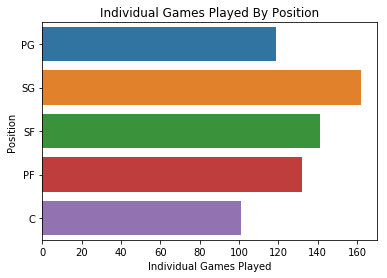

In [99]:
%matplotlib inline
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

positions = list(df1_dict.keys())
gms_played = list(df1_dict.values())

sns.barplot(x=gms_played, y=positions, order=['PG', 'SG', 'SF', 'PF', 'C'], orient='h')
plt.title('Individual Games Played By Position')
plt.xlabel('Individual Games Played')
plt.ylabel('Position')
plt.show()

We can see that SG was the position with the most individual games played over this period. 

Now let's create a scatter plot of Fanduel salary versus Fanduel points to get a rough idea of the point-per-dollar production of each player during this three-day period.

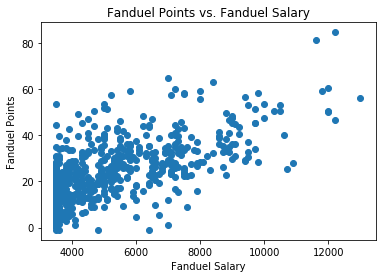

In [100]:
plt.scatter(x=df1['FD Salary'], y=df1['FD Pts'])
plt.title('Fanduel Points vs. Fanduel Salary')
plt.xlabel('Fanduel Salary')
plt.ylabel('Fanduel Points')
plt.show()

There appears to be a roughly linear relationship between the two, which is expected. Interestingly, there appears to be a lot of value evident here, i.e. there are many low-salary players who provided substantial output in Fanduel points. This indicates that finding value and hitting on low-priced players is the key to winning a Fanduel NBA contest.

Finally, let's plot the total individual players active by team during this three-day stretch. Some teams may have played two games during this period, so the total individual players activated will be more than the roster total for those teams (capped at 15 for all NBA teams).

In [96]:
team_count = df1['Team'].value_counts()

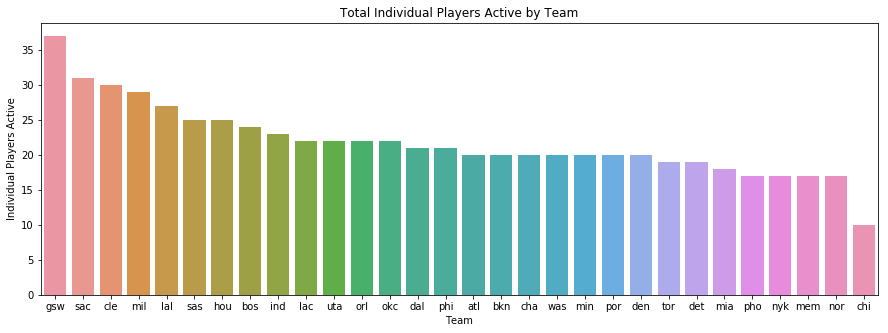

In [102]:
plt.figure(figsize=(15,5))
sns.barplot(team_count.index, team_count.values)
plt.title('Total Individual Players Active by Team')
plt.xlabel('Team')
plt.ylabel('Individual Players Active')
plt.show()

We can see that gsw (Golden State Warriors) had the most individual players active during this stretch, meaning they played two games and also went deep into their roster, utilizing a lot of their players. This makes sense, as the Warriors are known to play their bench players quite a lot. Most of the other teams did not seem to go too deep into their rosters, utilizing less bench players. It also appears that chi (Chicago Bulls) was the only team to play just a single game during this period.